### Project Chicago: Transform ResStock PACKAGE Results to Multi-family (RECS) Building Types
Created on: 01/07/2020 \
By: Lixi Liu (Lixi.Liu@nrel.gov)

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
print(f'Notebook path: {os.getcwd()}')

Notebook path: /Users/lliu2/Documents/GitHub/ResStock/files


### Download results online
* unprocessed upgrade results: S3/resbldg-datasets/chicagoeui
* processed result tables for plots: https://nrel.sharepoint.com/sites/ChicagoRetrofits/Shared%20Documents/Forms/AllItems.aspx?viewid=289cdd1a%2D97c9%2D4bcc%2D8416%2Dc19bf01c6302&id=%2Fsites%2FChicagoRetrofits%2FShared%20Documents%2FGeneral%2FUpgrade%20results

### Initialize
For modifying plots, can go directly to section 2.3 after initialization

In [3]:
# local path to downloaded results
iteration = '02_mf' # <----- options: '01'
iter_path = f'cookcnty_packages_{iteration}'
result_dir = '/Users/lliu2/Documents/Chicago retrofits/ResStock results'
result_path = os.path.join(result_dir, iter_path)

# accessory file path (for adding to package iteration)
acc_iter_path = f'cookcnty_upgrades_02'
acc_path = os.path.join(result_dir, acc_iter_path)

## create folder for post-processed results:
if not os.path.exists(os.path.join(result_path, 'processed results')):
    os.mkdir(os.path.join(result_path, 'processed results'))
    
## create folder for exported baseline and upgrade results to csv (to share with Elevate):
combined_res_csv_path = os.path.join(result_path, 'processed results', 'raw combined csvs')
if not os.path.exists(combined_res_csv_path):
    os.mkdir(combined_res_csv_path)
    
## create folder for plots:
plot_path = os.path.join(result_path, 'processed results', 'plots')
if not os.path.exists(plot_path):
    os.mkdir(plot_path)

print(f'Results path: \n   {result_path}')
print(f'Accessory files path: \n   {acc_path}')


Results path: 
   /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_02_mf
Accessory files path: 
   /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_upgrades_02


### Functions

In [4]:
def get_per_unit_sim_output(df, ref):
    """
    ref (df): baseline df
    """
    cols = [x for x in df.columns if 
            x.endswith('_kwh') or
            x.endswith('_mbtu') or
            x.endswith('_therm') or
            x.endswith('_cost_usd') or
            x.endswith('_ft_2')
           ]
    res = ref.set_index('building_id').reindex(df['building_id']).reset_index()
    df.loc[:, cols] = df.loc[:, cols].replace([None,''],np.nan).divide(
        res['build_existing_model.units_represented'], axis=0)
    
    return df
print('func loaded: "get_per_unit_sim_output"')

def get_per_unit_sim_output_limited(df, ref):
    """
    To reduce computing time
    ref (df): baseline df
    """
    cols = ['simulation_output_report.total_site_natural_gas_therm',
            'simulation_output_report.total_site_electricity_kwh',
            'simulation_output_report.total_site_energy_mbtu',
            'simulation_output_report.upgrade_cost_usd'
           ]
    res = ref.set_index('building_id').reindex(df['building_id']).reset_index()
    df.loc[:, cols] = df.loc[:, cols].replace([None,''],np.nan).divide(
        res['build_existing_model.units_represented'], axis=0)
    
    return df
print('func loaded: "get_per_unit_sim_output_limited"')

def add_sqft_eui(df, ref):
    """
    ARG:
        ref (df): baseline df
    RETURN:
        df with added cols: 'sqft', 'gas_eui', 'elec_eui', 'site_eui'
    """
    res = ref.set_index('building_id').reindex(df['building_id']).reset_index()
    df['sqft'] = res['simulation_output_report.floor_area_conditioned_ft_2']
    df['gas_eui'] = df['simulation_output_report.total_site_natural_gas_therm'].divide(df['sqft']) # therm/sqft
    df['elec_eui'] = df['simulation_output_report.total_site_electricity_kwh'].divide(df['sqft']) # kwh/sqft
    df['site_eui'] = df['simulation_output_report.total_site_energy_mbtu'].divide(df['sqft'])*1000 # kbtu/sqft
    
    for col in ['sqft','gas_eui','elec_eui','site_eui']:
        df.loc[df['simulation_output_report.applicable']==False, col] = np.nan
    
    return df
print('func loaded: "add_sqft_eui"')

def get_res_by_prototype(df, filter_by_df, row):
    """
    ARG:
        df (dataframe): df to slice on
        filter_by_df (dataframe): df used to do the slicing
    RETURN:
        filtered df (dataframe)
    """
    slice_by_df = filter_by_df.copy().set_index('building_id').reindex(df['building_id']).reset_index()
    res_group_i = df[slice_by_df['build_existing_model.geometry_stories'].isin(row['Stories'].split(',')) & \
        slice_by_df['build_existing_model.geometry_wall_type'].isin(row['WallType'].split(',')) & \
        slice_by_df['build_existing_model.vintage_acs'].isin(row['Vintage'].split(',')) & \
        slice_by_df['build_existing_model.geometry_building_type_recs'].isin(['Single-Family Detached'])]
    res_group_i = res_group_i[res_group_i['completed_status']=="Success"]
    
    return res_group_i
print('func loaded: "get_res_by_prototype"')

def load_upgrade(n, file_dir=result_path):
    """
    ARG:
        n (int, str): upgrade number
        file_dir (str): folder in which upgrade can be found, default to main result dir
    RETURN:
        df (dataframe) of upgrade n
    """
    df = pd.read_parquet(os.path.join(file_dir,'upgrades',
                                     f'upgrade={n}/results_up{n:02d}.parquet'))
    return df
print('func loaded: "load_upgrade"')



func loaded: "get_per_unit_sim_output"
func loaded: "get_per_unit_sim_output_limited"
func loaded: "add_sqft_eui"
func loaded: "get_res_by_prototype"
func loaded: "load_upgrade"


### 1. BASELINE results

In [5]:
save_a_copy_in_csv = False # <-----
res = pd.read_parquet(os.path.join(result_path,'baseline','results_up00.parquet'))

# (1) get sqft, gas/elec/site eui
res = add_sqft_eui(res, res)

if save_a_copy_in_csv:
    res.to_csv(os.path.join(combined_res_csv_path,'results_baseline.csv'), index=False)
    
# (1) get sim output at the unit level (req for MF)
res = get_per_unit_sim_output(res, res)

# (2) get sqft, gas/elec/site eui - redo to get unit-level results
res = add_sqft_eui(res, res)

# check
jobs_missing = set(range(1,246)) - set(res.job_id.unique())
print(f'- {len(jobs_missing)} jobs missing: {jobs_missing}')
print(f'- {16777-len(res)} buildings ({((16777-len(res))/16777*100):.2f}%)')

res

- 4 jobs missing: {57, 58, 59, 60}
- -3644 buildings (-21.72%)


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,build_existing_model.ahs_region,build_existing_model.applicable,...,qoi_report.average_of_top_ten_highest_peaks_timing_cooling_hour,qoi_report.average_of_top_ten_highest_peaks_timing_heating_hour,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,sqft,gas_eui,elec_eui,site_eui
0,1,170,2021-02-08 07:27:02,2021-02-08 07:28:29,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,15.636364,17.909091,35.439280,27.020355,4793.0,39.621348,1138.0,1.361800,9.549458,168.731619
1,2,204,2021-02-08 14:04:16,2021-02-08 14:19:31,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,16.272727,17.363636,157.113193,111.155287,5128.0,191.858633,1138.0,0.452631,4.967620,62.202515
2,3,13,2021-02-07 21:54:34,2021-02-07 21:57:55,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,16.181818,18.181818,102.139434,84.674223,6471.0,108.604937,2115.0,0.589579,5.329538,77.129004
3,4,117,2021-02-07 22:26:41,2021-02-07 22:28:05,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,15.454545,17.909091,22.218382,13.839910,4932.0,24.872680,853.0,0.771225,7.795249,103.702632
4,5,14,2021-02-08 10:55:48,2021-02-08 11:16:11,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,14.272727,10.818182,259.654645,686.901498,619.0,879.753971,853.0,0.000000,16.991971,57.978966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20416,20755,14,2021-02-07 19:47:40,2021-02-07 19:54:56,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,15.090909,10.454545,215.333442,308.773118,873.0,407.545486,1138.0,0.018703,21.472143,75.135820
20417,20756,241,2021-02-08 05:36:29,2021-02-08 06:23:04,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,12.909091,13.636364,669.868628,988.611318,641.0,1096.907897,617.0,0.031215,20.475008,72.984350
20418,20757,172,2021-02-08 03:55:44,2021-02-08 04:10:27,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,14.545455,13.636364,757.605008,672.887094,5103.0,886.638062,1138.0,0.424642,5.293667,60.516786
20419,20758,85,2021-02-07 21:24:33,2021-02-07 21:35:38,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,14.636364,6.000000,167.619891,778.660056,630.0,893.685975,853.0,0.000000,19.614254,66.926560


In [6]:
# assign heating/cooling
cooling_col = 'build_existing_model.hvac_cooling_type'
heating_col = 'build_existing_model.hvac_heating_type_and_fuel'
print('selected')

# if using a national run
if iteration == '_national_2018':
    res = res[res['build_existing_model.ahs_region']=='CBSA Chicago-Naperville-Elgin, IL-IN-WI'].reset_index(drop=True)
    res
    

selected


### 1.1. Check housing charateristics distributions in BASELINE

In [7]:
proto_chars = ['build_existing_model.geometry_stories',
              'build_existing_model.geometry_wall_type',
              'build_existing_model.vintage_acs',
              cooling_col,
              heating_col,
              'build_existing_model.geometry_floor_area'
             ]

Ns = len(res.query('completed_status=="Success"')); N = len(res)
print(f'>>> ResStock - {iter_path} - BASELINE result summary:\n')
print(f'  * {Ns} / {N} samples ran successfully, {N-Ns} failed, efficacy: {Ns/N:.1%} \n')

print('>>> Housing characteristics splits:\n')

Res_char = []
for i, char in enumerate(proto_chars,1):
    Nchar = res.groupby(char)['building_id'].count()
    Nchar = Nchar/Ns
    Nchar['N_failed'] = len(res[res[char].isnull()])
    print(f'  * [{i}] {Nchar}\n')
    
    ## append for export
    Nchar = Nchar.rename('fraction').to_frame()
    Nchar['housing_char'] = Nchar.index.name
    Res_char.append(Nchar)
    
Res_char = pd.concat(Res_char, axis=0)
Res_char.index.name = 'sub_char'
Res_char = Res_char.reset_index()
Res_char = Res_char[['housing_char','sub_char','fraction']]

Res_char.to_csv(os.path.join(result_path, 'baseline', 'baseline_housing_char_breakdown.csv'), index=False)
print(f'>>> file saved to:\n  {os.path.join(result_path, "baseline")}')

>>> ResStock - cookcnty_packages_02_mf - BASELINE result summary:

  * 20421 / 20421 samples ran successfully, 0 failed, efficacy: 100.0% 

>>> Housing characteristics splits:

  * [1] build_existing_model.geometry_stories
1           0.413692
2           0.201116
3           0.385192
N_failed    0.000000
Name: building_id, dtype: float64

  * [2] build_existing_model.geometry_wall_type
Masonry     0.877724
WoodStud    0.122276
N_failed    0.000000
Name: building_id, dtype: float64

  * [3] build_existing_model.vintage_acs
1940-59     0.147691
1960-79     0.248176
1980-99     0.142011
2000-09     0.091768
2010s       0.015621
<1940       0.354733
N_failed    0.000000
Name: building_id, dtype: float64

  * [4] build_existing_model.hvac_cooling_type
Central AC    0.422898
Heat Pump     0.041820
None          0.088536
Room AC       0.446746
N_failed      0.000000
Name: building_id, dtype: float64

  * [5] build_existing_model.hvac_heating_type_and_fuel
Electricity ASHP                    

### 1.2. Add additional metrics to Baseline

In [8]:
## EE prototype tags
res['vintage_ee'] = '3: post-1978'
res.loc[res['build_existing_model.vintage_acs'].isin(['1940-59','1960-79']),'vintage_ee'] = '2: 1942-1978'
res.loc[res['build_existing_model.vintage_acs']=='<1940','vintage_ee'] = '1: pre-1942'

res['stories'] = '2: 2+ stories'
res.loc[res['build_existing_model.geometry_stories']=='1','stories'] = '1: <2 stories'

print('new cols added to "res"')
res

new cols added to "res"


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,build_existing_model.ahs_region,build_existing_model.applicable,...,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,sqft,gas_eui,elec_eui,site_eui,vintage_ee,stories
0,1,170,2021-02-08 07:27:02,2021-02-08 07:28:29,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,35.439280,27.020355,4793.0,39.621348,1138.0,1.361800,9.549458,168.731619,2: 1942-1978,1: <2 stories
1,2,204,2021-02-08 14:04:16,2021-02-08 14:19:31,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,157.113193,111.155287,5128.0,191.858633,1138.0,0.452631,4.967620,62.202515,2: 1942-1978,2: 2+ stories
2,3,13,2021-02-07 21:54:34,2021-02-07 21:57:55,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,102.139434,84.674223,6471.0,108.604937,2115.0,0.589579,5.329538,77.129004,1: pre-1942,1: <2 stories
3,4,117,2021-02-07 22:26:41,2021-02-07 22:28:05,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,22.218382,13.839910,4932.0,24.872680,853.0,0.771225,7.795249,103.702632,2: 1942-1978,1: <2 stories
4,5,14,2021-02-08 10:55:48,2021-02-08 11:16:11,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,259.654645,686.901498,619.0,879.753971,853.0,0.000000,16.991971,57.978966,3: post-1978,2: 2+ stories
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20416,20755,14,2021-02-07 19:47:40,2021-02-07 19:54:56,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,215.333442,308.773118,873.0,407.545486,1138.0,0.018703,21.472143,75.135820,2: 1942-1978,2: 2+ stories
20417,20756,241,2021-02-08 05:36:29,2021-02-08 06:23:04,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,669.868628,988.611318,641.0,1096.907897,617.0,0.031215,20.475008,72.984350,3: post-1978,2: 2+ stories
20418,20757,172,2021-02-08 03:55:44,2021-02-08 04:10:27,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,757.605008,672.887094,5103.0,886.638062,1138.0,0.424642,5.293667,60.516786,3: post-1978,2: 2+ stories
20419,20758,85,2021-02-07 21:24:33,2021-02-07 21:35:38,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,167.619891,778.660056,630.0,893.685975,853.0,0.000000,19.614254,66.926560,3: post-1978,2: 2+ stories


## 2A. PACKAGE post processing ###
Three packages were ran as partitioned files. See "Cookcnty_packages_02.yml" for info
#### (1) Packages WITHOUT partitions (N=1, pkg 06)

In [9]:
def check_and_correct_for_missing_buildings(Pi, res, upgrade_no):
    delta = len(res)-len(Pi)
    if delta>0:
        print(f'   - upgrade_{upgrade_no:02d} is missing {delta} buildings compared to baseline')
    # always reindex
    Pi = Pi.set_index('building_id').reindex(res['building_id']).reset_index()
        
    return Pi

'func "check_and_correct_for_missing_buildings" loaded'

'func "check_and_correct_for_missing_buildings" loaded'

In [10]:
### (1) 
upgrade_list = [1,]
package_numbers = [6,]

print(f'packages without partitions: {len(upgrade_list)}')

for up, pk in zip(upgrade_list, package_numbers):
    file = f'package{pk:02d}.csv'
    filename = os.path.join(combined_res_csv_path, file)
    print(f'* {file}')

    if os.path.exists(filename):
        Pi = pd.read_csv(filename)

    else:
        Pi = load_upgrade(up, result_path)
        Pi = check_and_correct_for_missing_buildings(Pi, res, up)

        ## (3) save
        Pi.to_csv(filename, index=False)
    display(Pi)
    
print(f'\n>> file saved to: {combined_res_csv_path}')

packages without partitions: 1
* package06.csv
   - upgrade_01 is missing 31 buildings compared to baseline


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,simulation_output_report.applicable,simulation_output_report.door_area_ft_2,...,qoi_report.average_maximum_daily_use_overlap_kw,qoi_report.average_minimum_daily_use_cooling_kw,qoi_report.average_minimum_daily_use_heating_kw,qoi_report.average_minimum_daily_use_overlap_kw,qoi_report.average_of_top_ten_highest_peaks_timing_cooling_hour,qoi_report.average_of_top_ten_highest_peaks_timing_heating_hour,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw
0,1,42.0,2021-02-08 10:34:12,2021-02-08 10:37:03,Success,True,Utility Incentive Shell + LEDs,,True,40.0,...,17.067387,7.928824,5.583252,4.838073,15.727273,17.636364,33.961762,24.885217,4793.0,38.521395
1,2,244.0,2021-02-08 04:08:24,2021-02-08 04:25:35,Success,True,Utility Incentive Shell + LEDs,,True,180.0,...,73.391778,30.907102,16.566459,15.726707,16.181818,15.181818,143.913961,96.819789,5128.0,178.595873
2,3,61.0,2021-02-08 05:30:13,2021-02-08 05:34:44,Success,True,Utility Incentive Shell + LEDs,,True,80.0,...,46.692479,18.685313,7.409202,7.451741,15.727273,17.363636,94.457778,77.223798,6471.0,101.250343
3,4,50.0,2021-02-08 01:30:44,2021-02-08 01:33:28,Success,True,Utility Incentive Shell + LEDs,,True,40.0,...,12.428519,6.126783,2.914408,2.974963,15.909091,17.909091,22.183965,13.612700,4932.0,24.757517
4,5,224.0,2021-02-08 04:56:04,2021-02-08 05:17:31,Success,True,Utility Incentive Shell + LEDs,,True,240.0,...,159.924035,34.412698,117.463865,22.534211,14.272727,12.181818,250.961524,573.124919,619.0,741.520127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20416,20755,163.0,2021-02-08 07:33:07,2021-02-08 07:41:55,Success,True,Utility Incentive Shell + LEDs,,True,120.0,...,86.145578,15.070291,50.685497,7.433638,15.090909,11.000000,212.515811,287.954580,873.0,387.854856
20417,20756,119.0,2021-02-07 19:26:57,2021-02-07 20:14:14,Success,True,Utility Incentive Shell + LEDs,,True,360.0,...,474.965961,81.925224,183.050290,87.361690,12.363636,14.636364,648.840467,933.974818,641.0,1054.360849
20418,20757,19.0,2021-02-07 22:19:39,2021-02-07 22:35:19,Success,True,Utility Incentive Shell + LEDs,,True,180.0,...,417.120673,43.110794,46.793400,40.667803,13.818182,13.545455,753.542873,665.716627,5103.0,883.486691
20419,20758,169.0,2021-02-08 21:31:57,2021-02-08 21:44:06,Success,True,Utility Incentive Shell + LEDs,,True,180.0,...,115.569828,22.120926,30.522686,12.564971,14.636364,6.000000,165.933625,702.280936,174.0,806.120341



>> file saved to: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_02_mf/processed results/raw combined csvs


#### (2) Packages WITH single-level partitions (N=10, pkg 07-16)

In [11]:
# 2 partitiions over 'Attic Insulation'

def combine_df_from_first_level_partitions(pkg_no, upgrade_list, partition_para, options_list_for_first_upgrades, 
                                           MSHP_option=None, save_as_csv=True, recreate_from_scratch=True):
    global res
    """
    ARGS:
        pkg_no (int): package number to assign to combined df
        upgrade_list (list): list of ResStock upgrades to combine
        partition_para (str): para to filter the upgrades by and combine
        options_list_for_first_upgrades (list of list): list of para options to filter the first n-1 upgrades by
        MSHP_option (int): option number in package to correct, default to None
        save_as_csv (bool): default to True
        recreate_from_scratch (bool): default to True
    
    RETURN:
        P1: combined df
    """
    file = f'package{pkg_no:02d}.csv'
    filename = os.path.join(combined_res_csv_path, file)
    print(f'* {file}, from upgrades: {upgrade_list}')
    
    N = len(upgrade_list)
    partition_para = f'build_existing_model.{partition_para}'
    
    # check setting:
    if N-1 != len(options_list_for_first_upgrades):
        raise ValueError(f'The size of "options_list_for_first_upgrades" = {len(options_list_for_first_upgrades)}, '+
                         f'is not 1 less than the size of "upgrade_list" = {N}')

    if not os.path.exists(filename) or recreate_from_scratch:
        print(f'building from resstock results... partitioned by:\n  "{partition_para}"')

        ## (1) building ids for each partitions based on partition_para and para_options
        bldg_list = options_list = []; msg = ' '; n_bldgs = 0
        for n in range(N-1):
            bldgs_for_part_n = res[res[partition_para].isin(options_list_for_first_upgrades[n])]['building_id']
            bldg_list.append(bldgs_for_part_n)
            
            options_for_part_n = options_list_for_first_upgrades[n]
            options_list = options_list + options_for_part_n
            
            n_bldgs += len(bldgs_for_part_n)
            msg += f' part {n+1}: {len(bldgs_for_part_n)},'
        
        # for last partition:
        bldgs_for_part_n = res[~res[partition_para].isin(options_list)]['building_id']
        bldg_list.append(bldgs_for_part_n)
        
        n_bldgs += len(bldgs_for_part_n)
        msg += f' part {N}: {len(bldgs_for_part_n)}, total: {n_bldgs}'
        print(msg)

        ## (2) combine partitions and update upgrade name
        P1 = []
        for up, Bi in zip(upgrade_list, bldg_list):
            p = load_upgrade(up, result_path)
            p = check_and_correct_for_missing_buildings(p, res, up)
            P1.append(p[p['building_id'].isin(Bi)])

        P1 = pd.concat(P1, axis=0).sort_index()

        P1['apply_upgrade.upgrade_part'] = P1['apply_upgrade.upgrade_name'] # new col to show partition #
        P1['apply_upgrade.upgrade_name'] = P1['apply_upgrade.upgrade_name'].apply(
            lambda x: ' '.join(str(x).split(' ')[:-3])) # update name
        
        ## (3) correct MSHP costs
        if not MSHP_option == None:
            print('\nrecalculating MSHP cost...')
            MSHP_cost = f'simulation_output_report.option_{MSHP_option:02d}_cost_usd'
            
            # rename orig upgrade_cost col
            if not 'simulation_output_report.upgrade_cost_usd_orig' in P1.columns:
                P1['simulation_output_report.upgrade_cost_usd_orig'] = P1['simulation_output_report.upgrade_cost_usd']

            # copy upgrade_cost col
            P1['simulation_output_report.upgrade_cost_usd'] = P1['simulation_output_report.upgrade_cost_usd_orig']

            # remove old MSHP cost
            P1['simulation_output_report.upgrade_cost_usd'] -= P1[MSHP_cost]

            # recalc upgrade costs for MSHP
            idx = (P1['simulation_output_report.applicable']==True) & (res['build_existing_model.hvac_has_ducts']=='No')
            P1.loc[idx, MSHP_cost] = \
                710 + (95+1800/12)*P1.loc[idx, 'simulation_output_report.size_heating_system_kbtu_h']

            # calculate backup heating system size and cost
            supp_heat_cost = 38 # <--- 38(avg) 28-47 [$/kBtu_h]
            P1['simulation_output_report.size_heating_supp_system_kbtu_h_mshp'] = np.nan
            P1.loc[idx, 'simulation_output_report.size_heating_supp_system_kbtu_h_mshp'] = \
                P1.loc[idx, 'simulation_output_report.hvac_heating_supp_capacity_w']*3.412142/1000

            P1['simulation_output_report.upgrade_cost_usd_supp_heat_mshp'] = np.nan
            P1.loc[idx, 'simulation_output_report.upgrade_cost_usd_supp_heat_mshp'] = \
                supp_heat_cost * P1.loc[idx, 'simulation_output_report.size_heating_supp_system_kbtu_h_mshp']

            # add new MSHP and backup heat cost to 'upgrade_cost_usd'
            P1.loc[idx, 'simulation_output_report.upgrade_cost_usd'] += \
                P1.loc[idx, MSHP_cost]

            P1.loc[idx, 'simulation_output_report.upgrade_cost_usd'] += \
                P1.loc[idx, 'simulation_output_report.upgrade_cost_usd_supp_heat_mshp']

            # show
            print(f'>> package={pkg_no:02d} modified cols:')
            display(P1.loc[idx, ['apply_upgrade.upgrade_name',
                                'simulation_output_report.upgrade_cost_usd_orig',
                                'simulation_output_report.upgrade_cost_usd', # updated
                                'simulation_output_report.upgrade_cost_usd_supp_heat_mshp', # new
                                'simulation_output_report.size_heating_supp_system_kbtu_h_mshp', # new
                               ]])
        
        ## (4) save
        if save_as_csv:
            print(f'\n>> combined file saved to: {combined_res_csv_path}')
            P1.to_csv(filename, index=False)
            
    else:
        P1 = pd.read_csv(filename)

#     display(P1)
    return P1

print('func "combine_df_from_two_partitions"')


func "combine_df_from_two_partitions"


In [12]:
pkg_no = 7
upgrade_list = [2, 3]
partition_para = 'insulation_unfinished_attic'
options_list_for_first_upgrades = [
    ['Uninsulated, Vented','Ceiling R-7, Vented','Ceiling R-13, Vented'],
]
MSHP_option = None

combine_df_from_first_level_partitions(pkg_no, upgrade_list, partition_para, options_list_for_first_upgrades, 
                                       MSHP_option, save_as_csv=True, recreate_from_scratch=True)


* package07.csv, from upgrades: [2, 3]
building from resstock results... partitioned by:
  "build_existing_model.insulation_unfinished_attic"
  part 1: 0, part 2: 20421, total: 20421
   - upgrade_02 is missing 7 buildings compared to baseline

>> combined file saved to: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_02_mf/processed results/raw combined csvs


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,simulation_output_report.applicable,simulation_output_report.door_area_ft_2,...,qoi_report.average_minimum_daily_use_cooling_kw,qoi_report.average_minimum_daily_use_heating_kw,qoi_report.average_minimum_daily_use_overlap_kw,qoi_report.average_of_top_ten_highest_peaks_timing_cooling_hour,qoi_report.average_of_top_ten_highest_peaks_timing_heating_hour,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,apply_upgrade.upgrade_part
0,1,46.0,2021-02-08 03:12:04,2021-02-08 03:15:31,Success,True,Utility Incentive Shell + LEDs - Forced Air,,True,40.0,...,7.926903,5.610374,4.836418,15.727273,17.636364,33.973656,24.920763,4793.0,38.521327,Utility Incentive Shell + LEDs - Forced Air - ...
1,2,164.0,2021-02-08 10:50:32,2021-02-08 11:08:37,Success,True,Utility Incentive Shell + LEDs - Forced Air,,True,180.0,...,30.907196,16.697650,15.735255,16.181818,15.181818,143.913959,96.958179,5128.0,178.595872,Utility Incentive Shell + LEDs - Forced Air - ...
2,3,55.0,2021-02-08 11:11:50,2021-02-08 11:17:05,Success,True,Utility Incentive Shell + LEDs - Forced Air,,True,80.0,...,18.688626,7.425535,7.452862,15.727273,18.181818,94.457822,78.022566,6471.0,101.250336,Utility Incentive Shell + LEDs - Forced Air - ...
3,4,245.0,2021-02-08 13:55:35,2021-02-08 13:58:56,Success,True,Utility Incentive Shell + LEDs - Forced Air,,True,40.0,...,6.127615,2.925453,2.975776,15.909091,17.909091,22.184124,13.623684,4932.0,24.757670,Utility Incentive Shell + LEDs - Forced Air - ...
4,5,1.0,2021-02-08 12:02:42,2021-02-08 12:03:27,Invalid,True,Utility Incentive Shell + LEDs - Forced Air,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Utility Incentive Shell + LEDs - Forced Air - ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20416,20755,85.0,2021-02-08 09:19:42,2021-02-08 09:20:29,Invalid,True,Utility Incentive Shell + LEDs - Forced Air,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Utility Incentive Shell + LEDs - Forced Air - ...
20417,20756,25.0,2021-02-08 06:50:27,2021-02-08 06:51:21,Invalid,True,Utility Incentive Shell + LEDs - Forced Air,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Utility Incentive Shell + LEDs - Forced Air - ...
20418,20757,115.0,2021-02-08 07:42:48,2021-02-08 07:59:42,Success,True,Utility Incentive Shell + LEDs - Forced Air,,True,180.0,...,43.110445,47.137363,40.667986,13.818182,13.545455,753.541855,666.445965,5103.0,883.486797,Utility Incentive Shell + LEDs - Forced Air - ...
20419,20758,102.0,2021-02-08 05:14:17,2021-02-08 05:15:13,Invalid,True,Utility Incentive Shell + LEDs - Forced Air,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Utility Incentive Shell + LEDs - Forced Air - ...


In [13]:
pkg_no = 8
upgrade_list = [4, 5]
partition_para = 'infiltration'
options_list_for_first_upgrades = [
    ['50 ACH50','40 ACH50','30 ACH50','25 ACH50','20 ACH50','15 ACH50','10 ACH50','8 ACH50'],
]
MSHP_option = None

combine_df_from_first_level_partitions(pkg_no, upgrade_list, partition_para, options_list_for_first_upgrades, 
                                       MSHP_option, save_as_csv=True, recreate_from_scratch=True)


* package08.csv, from upgrades: [4, 5]
building from resstock results... partitioned by:
  "build_existing_model.infiltration"
  part 1: 18932, part 2: 1489, total: 20421

>> combined file saved to: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_02_mf/processed results/raw combined csvs


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,simulation_output_report.applicable,simulation_output_report.door_area_ft_2,...,qoi_report.average_minimum_daily_use_cooling_kw,qoi_report.average_minimum_daily_use_heating_kw,qoi_report.average_minimum_daily_use_overlap_kw,qoi_report.average_of_top_ten_highest_peaks_timing_cooling_hour,qoi_report.average_of_top_ten_highest_peaks_timing_heating_hour,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,apply_upgrade.upgrade_part
0,1,73.0,2021-02-08 11:36:09,2021-02-08 11:40:22,Success,True,Utility Incentive Shell + LEDs + Appliances - ...,,True,40.0,...,7.542604,5.387337,4.802371,15.727273,17.636364,32.976173,24.624491,4793.0,38.430811,Utility Incentive Shell + LEDs + Appliances - ...
1,2,192.0,2021-02-08 05:39:17,2021-02-08 05:57:27,Success,True,Utility Incentive Shell + LEDs + Appliances - ...,,True,180.0,...,27.431713,15.797637,14.445226,16.181818,15.181818,136.105123,95.630622,5128.0,171.890025,Utility Incentive Shell + LEDs + Appliances - ...
2,3,228.0,2021-02-08 19:06:50,2021-02-08 19:13:37,Success,True,Utility Incentive Shell + LEDs + Appliances - ...,,True,80.0,...,16.375229,7.141457,7.315508,15.727273,17.363636,81.349430,68.360159,6471.0,88.900834,Utility Incentive Shell + LEDs + Appliances - ...
3,4,105.0,2021-02-08 00:03:17,2021-02-08 00:07:37,Success,True,Utility Incentive Shell + LEDs + Appliances - ...,,True,40.0,...,5.715226,2.840710,2.815037,15.636364,17.909091,22.004024,13.419261,4932.0,24.206605,Utility Incentive Shell + LEDs + Appliances - ...
4,5,81.0,2021-02-08 05:17:49,2021-02-08 05:18:36,Invalid,True,Utility Incentive Shell + LEDs + Appliances - ...,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Utility Incentive Shell + LEDs + Appliances - ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20416,20755,215.0,2021-02-08 06:46:07,2021-02-08 06:46:54,Invalid,True,Utility Incentive Shell + LEDs + Appliances - ...,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Utility Incentive Shell + LEDs + Appliances - ...
20417,20756,110.0,2021-02-07 23:13:21,2021-02-07 23:14:19,Invalid,True,Utility Incentive Shell + LEDs + Appliances - ...,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Utility Incentive Shell + LEDs + Appliances - ...
20418,20757,119.0,2021-02-08 02:07:32,2021-02-08 02:25:42,Success,True,Utility Incentive Shell + LEDs + Appliances - ...,,True,180.0,...,40.496696,44.111386,39.390066,13.818182,14.000000,564.195490,486.499410,5103.0,696.067665,Utility Incentive Shell + LEDs + Appliances - ...
20419,20758,127.0,2021-02-08 04:08:30,2021-02-08 04:09:25,Invalid,True,Utility Incentive Shell + LEDs + Appliances - ...,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Utility Incentive Shell + LEDs + Appliances - ...


In [14]:
pkg_no = 9
upgrade_list = [6, 7]
partition_para = 'infiltration'
options_list_for_first_upgrades = [
    ['50 ACH50','40 ACH50','30 ACH50','25 ACH50','20 ACH50','15 ACH50','10 ACH50','8 ACH50'],
]
MSHP_option = None

combine_df_from_first_level_partitions(pkg_no, upgrade_list, partition_para, options_list_for_first_upgrades, 
                                       MSHP_option, save_as_csv=True, recreate_from_scratch=True)


* package09.csv, from upgrades: [6, 7]
building from resstock results... partitioned by:
  "build_existing_model.infiltration"
  part 1: 18932, part 2: 1489, total: 20421
   - upgrade_07 is missing 13 buildings compared to baseline

>> combined file saved to: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_02_mf/processed results/raw combined csvs


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,simulation_output_report.applicable,simulation_output_report.door_area_ft_2,...,qoi_report.average_minimum_daily_use_cooling_kw,qoi_report.average_minimum_daily_use_heating_kw,qoi_report.average_minimum_daily_use_overlap_kw,qoi_report.average_of_top_ten_highest_peaks_timing_cooling_hour,qoi_report.average_of_top_ten_highest_peaks_timing_heating_hour,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,apply_upgrade.upgrade_part
0,1,147.0,2021-02-08 01:18:29,2021-02-08 01:19:09,Invalid,True,Utility Incentive Shell + WH - Hydronic,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Utility Incentive Shell + WH - Hydronic - Part 1
1,2,31.0,2021-02-08 13:15:51,2021-02-08 13:16:34,Invalid,True,Utility Incentive Shell + WH - Hydronic,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Utility Incentive Shell + WH - Hydronic - Part 1
2,3,208.0,2021-02-08 16:15:47,2021-02-08 16:16:39,Invalid,True,Utility Incentive Shell + WH - Hydronic,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Utility Incentive Shell + WH - Hydronic - Part 1
3,4,197.0,2021-02-08 16:01:20,2021-02-08 16:02:06,Invalid,True,Utility Incentive Shell + WH - Hydronic,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Utility Incentive Shell + WH - Hydronic - Part 1
4,5,98.0,2021-02-08 01:21:49,2021-02-08 01:22:36,Invalid,True,Utility Incentive Shell + WH - Hydronic,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Utility Incentive Shell + WH - Hydronic - Part 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20416,20755,1.0,2021-02-08 11:44:57,2021-02-08 11:45:47,Invalid,True,Utility Incentive Shell + WH - Hydronic,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Utility Incentive Shell + WH - Hydronic - Part 1
20417,20756,40.0,2021-02-07 22:21:38,2021-02-07 22:22:35,Invalid,True,Utility Incentive Shell + WH - Hydronic,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Utility Incentive Shell + WH - Hydronic - Part 1
20418,20757,145.0,2021-02-08 03:54:12,2021-02-08 03:54:59,Invalid,True,Utility Incentive Shell + WH - Hydronic,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Utility Incentive Shell + WH - Hydronic - Part 1
20419,20758,117.0,2021-02-08 05:40:56,2021-02-08 05:41:49,Invalid,True,Utility Incentive Shell + WH - Hydronic,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Utility Incentive Shell + WH - Hydronic - Part 1


In [15]:
pkg_no = 10
upgrade_list = [8, 9]
partition_para = 'infiltration'
options_list_for_first_upgrades = [
    ['50 ACH50','40 ACH50','30 ACH50','25 ACH50','20 ACH50','15 ACH50','10 ACH50','8 ACH50'],
]
MSHP_option = None

combine_df_from_first_level_partitions(pkg_no, upgrade_list, partition_para, options_list_for_first_upgrades, 
                                       MSHP_option, save_as_csv=True, recreate_from_scratch=True)


* package10.csv, from upgrades: [8, 9]
building from resstock results... partitioned by:
  "build_existing_model.infiltration"
  part 1: 18932, part 2: 1489, total: 20421

>> combined file saved to: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_02_mf/processed results/raw combined csvs


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,simulation_output_report.applicable,simulation_output_report.door_area_ft_2,...,qoi_report.average_minimum_daily_use_cooling_kw,qoi_report.average_minimum_daily_use_heating_kw,qoi_report.average_minimum_daily_use_overlap_kw,qoi_report.average_of_top_ten_highest_peaks_timing_cooling_hour,qoi_report.average_of_top_ten_highest_peaks_timing_heating_hour,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,apply_upgrade.upgrade_part
0,1,135.0,2021-02-08 11:53:37,2021-02-08 11:54:18,Invalid,True,Utility Incentive Shell + LEDs + Appliances - ...,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Utility Incentive Shell + LEDs + Appliances - ...
1,2,158.0,2021-02-08 08:15:36,2021-02-08 08:16:22,Invalid,True,Utility Incentive Shell + LEDs + Appliances - ...,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Utility Incentive Shell + LEDs + Appliances - ...
2,3,239.0,2021-02-08 07:17:31,2021-02-08 07:18:23,Invalid,True,Utility Incentive Shell + LEDs + Appliances - ...,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Utility Incentive Shell + LEDs + Appliances - ...
3,4,152.0,2021-02-07 23:26:59,2021-02-07 23:27:42,Invalid,True,Utility Incentive Shell + LEDs + Appliances - ...,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Utility Incentive Shell + LEDs + Appliances - ...
4,5,80.0,2021-02-08 10:54:30,2021-02-08 10:55:19,Invalid,True,Utility Incentive Shell + LEDs + Appliances - ...,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Utility Incentive Shell + LEDs + Appliances - ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20416,20755,42.0,2021-02-08 03:29:05,2021-02-08 03:29:55,Invalid,True,Utility Incentive Shell + LEDs + Appliances - ...,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Utility Incentive Shell + LEDs + Appliances - ...
20417,20756,139.0,2021-02-08 02:13:59,2021-02-08 02:14:54,Invalid,True,Utility Incentive Shell + LEDs + Appliances - ...,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Utility Incentive Shell + LEDs + Appliances - ...
20418,20757,175.0,2021-02-08 13:54:24,2021-02-08 13:55:13,Invalid,True,Utility Incentive Shell + LEDs + Appliances - ...,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Utility Incentive Shell + LEDs + Appliances - ...
20419,20758,215.0,2021-02-08 18:30:10,2021-02-08 18:31:02,Invalid,True,Utility Incentive Shell + LEDs + Appliances - ...,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Utility Incentive Shell + LEDs + Appliances - ...


In [16]:
pkg_no = 11
upgrade_list = [10, 11]
partition_para = 'infiltration'
options_list_for_first_upgrades = [
    ['50 ACH50','40 ACH50','30 ACH50','25 ACH50','20 ACH50','15 ACH50','10 ACH50','8 ACH50'],
]
MSHP_option = None

combine_df_from_first_level_partitions(pkg_no, upgrade_list, partition_para, options_list_for_first_upgrades, 
                                       MSHP_option, save_as_csv=True, recreate_from_scratch=True)


* package11.csv, from upgrades: [10, 11]
building from resstock results... partitioned by:
  "build_existing_model.infiltration"
  part 1: 18932, part 2: 1489, total: 20421
   - upgrade_11 is missing 7 buildings compared to baseline

>> combined file saved to: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_02_mf/processed results/raw combined csvs


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,simulation_output_report.applicable,simulation_output_report.door_area_ft_2,...,qoi_report.average_minimum_daily_use_cooling_kw,qoi_report.average_minimum_daily_use_heating_kw,qoi_report.average_minimum_daily_use_overlap_kw,qoi_report.average_of_top_ten_highest_peaks_timing_cooling_hour,qoi_report.average_of_top_ten_highest_peaks_timing_heating_hour,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,apply_upgrade.upgrade_part
0,1,157.0,2021-02-08 07:49:19,2021-02-08 07:53:37,Success,True,Comprehensive - Forced Air + WH + Shell,,True,40.0,...,7.706734,5.412711,4.946413,15.727273,17.818182,32.965476,24.689428,4793.0,38.541800,Comprehensive - Forced Air + WH + Shell - Part 1
1,2,88.0,2021-02-07 21:13:52,2021-02-07 21:32:11,Success,True,Comprehensive - Forced Air + WH + Shell,,True,180.0,...,29.321375,16.187761,16.108759,16.545455,15.181818,135.335610,96.508077,5128.0,170.756282,Comprehensive - Forced Air + WH + Shell - Part 1
2,3,234.0,2021-02-08 17:56:19,2021-02-08 18:02:26,Success,True,Comprehensive - Forced Air + WH + Shell,,True,80.0,...,16.202583,7.168497,7.729696,15.727273,17.363636,86.777937,76.425212,857.0,90.340219,Comprehensive - Forced Air + WH + Shell - Part 1
3,4,147.0,2021-02-08 11:53:17,2021-02-08 11:57:22,Success,True,Comprehensive - Forced Air + WH + Shell,,True,40.0,...,6.006429,2.881312,3.083276,16.818182,17.909091,21.957491,13.525778,4932.0,23.926966,Comprehensive - Forced Air + WH + Shell - Part 1
4,5,79.0,2021-02-07 20:11:56,2021-02-07 20:12:42,Invalid,True,Comprehensive - Forced Air + WH + Shell,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - Forced Air + WH + Shell - Part 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20416,20755,98.0,2021-02-07 21:30:24,2021-02-07 21:31:14,Invalid,True,Comprehensive - Forced Air + WH + Shell,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - Forced Air + WH + Shell - Part 1
20417,20756,123.0,2021-02-08 03:35:57,2021-02-08 03:36:51,Invalid,True,Comprehensive - Forced Air + WH + Shell,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - Forced Air + WH + Shell - Part 1
20418,20757,21.0,2021-02-08 00:58:30,2021-02-08 01:17:00,Success,True,Comprehensive - Forced Air + WH + Shell,,True,180.0,...,43.276328,45.590574,41.894160,13.818182,13.545455,745.776391,663.547937,5103.0,878.207498,Comprehensive - Forced Air + WH + Shell - Part 1
20419,20758,208.0,2021-02-08 07:06:58,2021-02-08 07:07:50,Invalid,True,Comprehensive - Forced Air + WH + Shell,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - Forced Air + WH + Shell - Part 1


In [17]:
pkg_no = 12
upgrade_list = [12, 13, 14]
partition_para = 'infiltration'
options_list_for_first_upgrades = [
    ['50 ACH50','40 ACH50','30 ACH50','25 ACH50','20 ACH50','15 ACH50'],
    ['10 ACH50','8 ACH50','7 ACH50','6 ACH50'],
]
MSHP_option = None

combine_df_from_first_level_partitions(pkg_no, upgrade_list, partition_para, options_list_for_first_upgrades, 
                                       MSHP_option, save_as_csv=True, recreate_from_scratch=True)


* package12.csv, from upgrades: [12, 13, 14]
building from resstock results... partitioned by:
  "build_existing_model.infiltration"
  part 1: 16878, part 2: 2947, part 3: 596, total: 20421
   - upgrade_13 is missing 12 buildings compared to baseline
   - upgrade_14 is missing 25 buildings compared to baseline

>> combined file saved to: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_02_mf/processed results/raw combined csvs


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,simulation_output_report.applicable,simulation_output_report.door_area_ft_2,...,qoi_report.average_minimum_daily_use_cooling_kw,qoi_report.average_minimum_daily_use_heating_kw,qoi_report.average_minimum_daily_use_overlap_kw,qoi_report.average_of_top_ten_highest_peaks_timing_cooling_hour,qoi_report.average_of_top_ten_highest_peaks_timing_heating_hour,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,apply_upgrade.upgrade_part
0,1,50.0,2021-02-08 09:29:41,2021-02-08 09:33:41,Success,True,Comprehensive - Forced Air + WH + Insulation +...,,True,40.0,...,7.649822,5.457929,4.894114,15.727273,17.636364,33.103946,24.716112,4793.0,38.543753,Comprehensive - Forced Air + WH + Insulation +...
1,2,208.0,2021-02-08 09:10:47,2021-02-08 09:28:54,Success,True,Comprehensive - Forced Air + WH + Insulation +...,,True,180.0,...,28.736231,16.631556,15.513074,16.181818,15.181818,137.711054,96.655468,5128.0,173.428055,Comprehensive - Forced Air + WH + Insulation +...
2,3,155.0,2021-02-08 12:23:56,2021-02-08 12:30:53,Success,True,Comprehensive - Forced Air + WH + Insulation +...,,True,80.0,...,16.540234,7.293125,7.510887,14.181818,18.181818,65.870308,51.537211,4712.0,76.820405,Comprehensive - Forced Air + WH + Insulation +...
3,4,151.0,2021-02-08 03:05:00,2021-02-08 03:09:14,Success,True,Comprehensive - Forced Air + WH + Insulation +...,,True,40.0,...,5.897427,2.947893,2.961651,15.636364,17.909091,22.182245,13.584627,4932.0,24.408769,Comprehensive - Forced Air + WH + Insulation +...
4,5,43.0,2021-02-08 02:45:19,2021-02-08 02:46:09,Invalid,True,Comprehensive - Forced Air + WH + Insulation +...,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - Forced Air + WH + Insulation +...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20416,20755,203.0,2021-02-08 20:25:18,2021-02-08 20:26:04,Invalid,True,Comprehensive - Forced Air + WH + Insulation +...,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - Forced Air + WH + Insulation +...
20417,20756,127.0,2021-02-08 07:52:16,2021-02-08 07:53:14,Invalid,True,Comprehensive - Forced Air + WH + Insulation +...,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - Forced Air + WH + Insulation +...
20418,20757,87.0,2021-02-08 07:14:06,2021-02-08 07:32:28,Success,True,Comprehensive - Forced Air + WH + Insulation +...,,True,180.0,...,43.280194,46.393453,41.883413,13.909091,15.181818,443.149885,370.777293,5103.0,568.604047,Comprehensive - Forced Air + WH + Insulation +...
20419,20758,163.0,2021-02-08 15:16:24,2021-02-08 15:17:18,Invalid,True,Comprehensive - Forced Air + WH + Insulation +...,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - Forced Air + WH + Insulation +...


In [18]:
pkg_no = 13
upgrade_list = [15, 16]
partition_para = 'infiltration'
options_list_for_first_upgrades = [
    ['50 ACH50','40 ACH50','30 ACH50','25 ACH50','20 ACH50','15 ACH50','10 ACH50','8 ACH50'],
]
MSHP_option = None

combine_df_from_first_level_partitions(pkg_no, upgrade_list, partition_para, options_list_for_first_upgrades, 
                                       MSHP_option, save_as_csv=True, recreate_from_scratch=True)


* package13.csv, from upgrades: [15, 16]
building from resstock results... partitioned by:
  "build_existing_model.infiltration"
  part 1: 18932, part 2: 1489, total: 20421
   - upgrade_16 is missing 20 buildings compared to baseline

>> combined file saved to: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_02_mf/processed results/raw combined csvs


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,simulation_output_report.applicable,simulation_output_report.door_area_ft_2,...,qoi_report.average_minimum_daily_use_cooling_kw,qoi_report.average_minimum_daily_use_heating_kw,qoi_report.average_minimum_daily_use_overlap_kw,qoi_report.average_of_top_ten_highest_peaks_timing_cooling_hour,qoi_report.average_of_top_ten_highest_peaks_timing_heating_hour,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,apply_upgrade.upgrade_part
0,1,222.0,2021-02-08 07:12:05,2021-02-08 07:12:45,Invalid,True,Comprehensive - Hydronic + WH + Shell,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - Hydronic + WH + Shell - Part 1
1,2,163.0,2021-02-08 03:41:34,2021-02-08 03:42:16,Invalid,True,Comprehensive - Hydronic + WH + Shell,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - Hydronic + WH + Shell - Part 1
2,3,222.0,2021-02-08 04:01:16,2021-02-08 04:02:06,Invalid,True,Comprehensive - Hydronic + WH + Shell,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - Hydronic + WH + Shell - Part 1
3,4,177.0,2021-02-08 20:37:53,2021-02-08 20:38:35,Invalid,True,Comprehensive - Hydronic + WH + Shell,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - Hydronic + WH + Shell - Part 1
4,5,201.0,2021-02-08 04:12:32,2021-02-08 04:13:18,Invalid,True,Comprehensive - Hydronic + WH + Shell,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - Hydronic + WH + Shell - Part 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20416,20755,225.0,2021-02-08 05:06:41,2021-02-08 05:07:27,Invalid,True,Comprehensive - Hydronic + WH + Shell,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - Hydronic + WH + Shell - Part 1
20417,20756,91.0,2021-02-08 02:08:05,2021-02-08 02:09:02,Invalid,True,Comprehensive - Hydronic + WH + Shell,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - Hydronic + WH + Shell - Part 1
20418,20757,171.0,2021-02-08 12:28:12,2021-02-08 12:29:04,Invalid,True,Comprehensive - Hydronic + WH + Shell,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - Hydronic + WH + Shell - Part 1
20419,20758,16.0,2021-02-08 06:38:09,2021-02-08 06:39:04,Invalid,True,Comprehensive - Hydronic + WH + Shell,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - Hydronic + WH + Shell - Part 1


In [19]:
pkg_no = 14
upgrade_list = [17, 18, 19, 20]
partition_para = 'infiltration'
options_list_for_first_upgrades = [
    ['50 ACH50','40 ACH50','30 ACH50','25 ACH50'],
    ['20 ACH50','15 ACH50','10 ACH50','8 ACH50'],
    ['7 ACH50','6 ACH50','5 ACH50'],
]
MSHP_option = None

combine_df_from_first_level_partitions(pkg_no, upgrade_list, partition_para, options_list_for_first_upgrades, 
                                       MSHP_option, save_as_csv=True, recreate_from_scratch=True)



* package14.csv, from upgrades: [17, 18, 19, 20]
building from resstock results... partitioned by:
  "build_existing_model.infiltration"
  part 1: 9482, part 2: 9450, part 3: 1188, part 4: 301, total: 20421
   - upgrade_17 is missing 7 buildings compared to baseline
   - upgrade_18 is missing 7 buildings compared to baseline
   - upgrade_19 is missing 33 buildings compared to baseline
   - upgrade_20 is missing 29 buildings compared to baseline

>> combined file saved to: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_02_mf/processed results/raw combined csvs


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,simulation_output_report.applicable,simulation_output_report.door_area_ft_2,...,qoi_report.average_minimum_daily_use_cooling_kw,qoi_report.average_minimum_daily_use_heating_kw,qoi_report.average_minimum_daily_use_overlap_kw,qoi_report.average_of_top_ten_highest_peaks_timing_cooling_hour,qoi_report.average_of_top_ten_highest_peaks_timing_heating_hour,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,apply_upgrade.upgrade_part
0,1,244.0,2021-02-08 09:29:53,2021-02-08 09:30:36,Invalid,True,Comprehensive - Hydronic + WH + Shell + Applia...,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - Hydronic + WH + Shell + Applia...
1,2,235.0,2021-02-08 17:16:01,2021-02-08 17:16:48,Invalid,True,Comprehensive - Hydronic + WH + Shell + Applia...,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - Hydronic + WH + Shell + Applia...
2,3,131.0,2021-02-08 05:36:41,2021-02-08 05:37:34,Invalid,True,Comprehensive - Hydronic + WH + Shell + Applia...,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - Hydronic + WH + Shell + Applia...
3,4,106.0,2021-02-08 08:20:11,2021-02-08 08:20:53,Invalid,True,Comprehensive - Hydronic + WH + Shell + Applia...,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - Hydronic + WH + Shell + Applia...
4,5,96.0,2021-02-08 07:18:51,2021-02-08 07:19:37,Invalid,True,Comprehensive - Hydronic + WH + Shell + Applia...,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - Hydronic + WH + Shell + Applia...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20416,20755,32.0,2021-02-08 03:05:19,2021-02-08 03:06:07,Invalid,True,Comprehensive - Hydronic + WH + Shell + Applia...,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - Hydronic + WH + Shell + Applia...
20417,20756,144.0,2021-02-08 00:13:18,2021-02-08 00:14:17,Invalid,True,Comprehensive - Hydronic + WH + Shell + Applia...,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - Hydronic + WH + Shell + Applia...
20418,20757,3.0,2021-02-08 07:10:54,2021-02-08 07:11:48,Invalid,True,Comprehensive - Hydronic + WH + Shell + Applia...,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - Hydronic + WH + Shell + Applia...
20419,20758,197.0,2021-02-08 07:47:23,2021-02-08 07:48:17,Invalid,True,Comprehensive - Hydronic + WH + Shell + Applia...,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - Hydronic + WH + Shell + Applia...


In [20]:
pkg_no = 15
upgrade_list = [21, 22]
partition_para = 'infiltration'
options_list_for_first_upgrades = [
    ['50 ACH50','40 ACH50','30 ACH50','25 ACH50','20 ACH50','15 ACH50','10 ACH50','8 ACH50'],
]
MSHP_option = None

combine_df_from_first_level_partitions(pkg_no, upgrade_list, partition_para, options_list_for_first_upgrades, 
                                       MSHP_option, save_as_csv=True, recreate_from_scratch=True)


* package15.csv, from upgrades: [21, 22]
building from resstock results... partitioned by:
  "build_existing_model.infiltration"
  part 1: 18932, part 2: 1489, total: 20421
   - upgrade_21 is missing 14 buildings compared to baseline

>> combined file saved to: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_02_mf/processed results/raw combined csvs


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,simulation_output_report.applicable,simulation_output_report.door_area_ft_2,...,qoi_report.average_minimum_daily_use_cooling_kw,qoi_report.average_minimum_daily_use_heating_kw,qoi_report.average_minimum_daily_use_overlap_kw,qoi_report.average_of_top_ten_highest_peaks_timing_cooling_hour,qoi_report.average_of_top_ten_highest_peaks_timing_heating_hour,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,apply_upgrade.upgrade_part
0,1,170.0,2021-02-08 18:10:39,2021-02-08 18:14:44,Success,True,Comprehensive - ASHP,,True,40.0,...,5.781481,18.235155,4.840785,15.454545,9.272727,32.243241,127.852936,632.0,148.779303,Comprehensive - ASHP - Part 1
1,2,115.0,2021-02-08 06:41:23,2021-02-08 07:00:58,Success,True,Comprehensive - ASHP,,True,180.0,...,18.172565,42.164151,14.572307,14.090909,10.090909,103.140531,352.906840,630.0,399.055008,Comprehensive - ASHP - Part 1
2,3,145.0,2021-02-08 12:32:10,2021-02-08 12:38:23,Success,True,Comprehensive - ASHP,,True,80.0,...,8.784858,14.794793,6.360520,15.181818,12.181818,75.512299,259.442499,619.0,308.321659,Comprehensive - ASHP - Part 1
3,4,33.0,2021-02-07 21:25:18,2021-02-07 21:29:29,Success,True,Comprehensive - ASHP,,True,40.0,...,3.338963,8.114534,2.611518,16.545455,10.181818,16.474158,60.553234,630.0,70.346035,Comprehensive - ASHP - Part 1
4,5,26.0,2021-02-07 19:46:56,2021-02-07 19:47:40,Invalid,True,Comprehensive - ASHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - ASHP - Part 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20416,20755,201.0,2021-02-08 04:19:03,2021-02-08 04:19:51,Invalid,True,Comprehensive - ASHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - ASHP - Part 1
20417,20756,72.0,2021-02-08 13:00:55,2021-02-08 13:01:51,Invalid,True,Comprehensive - ASHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - ASHP - Part 1
20418,20757,136.0,2021-02-07 23:06:48,2021-02-07 23:26:27,Success,True,Comprehensive - ASHP,,True,180.0,...,42.679606,68.501590,42.676493,13.818182,9.272727,689.597272,1023.561090,643.0,1311.825296,Comprehensive - ASHP - Part 1
20419,20758,82.0,2021-02-07 21:23:54,2021-02-07 21:24:47,Invalid,True,Comprehensive - ASHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - ASHP - Part 1


In [21]:
pkg_no = 16
upgrade_list = [23, 24]
partition_para = 'infiltration'
options_list_for_first_upgrades = [
    ['50 ACH50','40 ACH50','30 ACH50','25 ACH50','20 ACH50','15 ACH50','10 ACH50','8 ACH50'],
]
MSHP_option = None #4

combine_df_from_first_level_partitions(pkg_no, upgrade_list, partition_para, options_list_for_first_upgrades, 
                                       MSHP_option, save_as_csv=True, recreate_from_scratch=True)


* package16.csv, from upgrades: [23, 24]
building from resstock results... partitioned by:
  "build_existing_model.infiltration"
  part 1: 18932, part 2: 1489, total: 20421

>> combined file saved to: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_02_mf/processed results/raw combined csvs


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,simulation_output_report.applicable,simulation_output_report.door_area_ft_2,...,qoi_report.average_minimum_daily_use_cooling_kw,qoi_report.average_minimum_daily_use_heating_kw,qoi_report.average_minimum_daily_use_overlap_kw,qoi_report.average_of_top_ten_highest_peaks_timing_cooling_hour,qoi_report.average_of_top_ten_highest_peaks_timing_heating_hour,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,apply_upgrade.upgrade_part
0,1,175.0,2021-02-08 08:42:40,2021-02-08 08:43:23,Invalid,True,Comprehensive - MSHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - MSHP - Part 1
1,2,172.0,2021-02-08 09:01:54,2021-02-08 09:02:38,Invalid,True,Comprehensive - MSHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - MSHP - Part 1
2,3,16.0,2021-02-08 03:52:21,2021-02-08 03:53:15,Invalid,True,Comprehensive - MSHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - MSHP - Part 1
3,4,84.0,2021-02-08 02:37:37,2021-02-08 02:38:20,Invalid,True,Comprehensive - MSHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - MSHP - Part 1
4,5,227.0,2021-02-08 14:39:05,2021-02-08 14:39:52,Invalid,True,Comprehensive - MSHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - MSHP - Part 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20416,20755,215.0,2021-02-08 05:49:07,2021-02-08 05:49:58,Invalid,True,Comprehensive - MSHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - MSHP - Part 1
20417,20756,134.0,2021-02-07 23:56:25,2021-02-07 23:57:18,Invalid,True,Comprehensive - MSHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - MSHP - Part 1
20418,20757,101.0,2021-02-08 07:00:28,2021-02-08 07:01:17,Invalid,True,Comprehensive - MSHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - MSHP - Part 1
20419,20758,208.0,2021-02-08 09:35:52,2021-02-08 09:36:46,Invalid,True,Comprehensive - MSHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - MSHP - Part 1


#### (3) Packages WITH multi-level partitions (N=4, pkg 17-20)

In [22]:
def combine_df_from_two_level_partitions(pkg_no, upgrade_list, level1_list, level2_list, MSHP_option=None, 
                                         fix_upgrade_name=False, save_as_csv=True, recreate_from_scratch=True):
    global res
    """
    ARGS:
        pkg_no (int): package number to assign to combined df
        upgrade_list (list): list of ResStock upgrades to combine
        level1_list (list of dict): list of dictionaries defining the level 1 partition key and options
        level2_list (list of dict): list of dictionaries defining the level 2 partition key and options
        MSHP_option (int): option number in package to correct, default to None
        fix_upgrade_name (bool): default to True, for pkg 21-24 only
        save_as_csv (bool): default to True
        recreate_from_scratch (bool): default to True
    
    RETURN:
        P1: combined df
    """
    
    file = f'package{pkg_no:02d}.csv'
    filename = os.path.join(combined_res_csv_path, file)
    print(f'* {file}, from upgrades: {upgrade_list}')
    
    N_upgrades = len(upgrade_list)
    N_partitions = len(level1_list)*len(level2_list)
    if N_upgrades != N_partitions:
        raise ValueError(f'The size of "upgrade_list" = {N_upgrades} does not match the number of enumeration from '+
                        f'"level1_list" and "level2_list" = {N_partitions}')
    
    if not os.path.exists(filename) or recreate_from_scratch:
        
        print(f'building from resstock run results, {N_partitions} partitions...\n')

        ## building ids for each partitions
        bldg_list = []; CBi_len = 0

        ##### level 1
        P4C1 = level1_list # <----
        for i , Ci in enumerate(P4C1,1):
            CBi = set()
            for key, lst in Ci.items():
                Bi = res[res[f'build_existing_model.{key}'].replace({np.nan:'None'}).isin(lst)]['building_id']
                CBi = CBi.union(set(list(Bi)))
                print(f'- 1.{i} {key}, {len(Bi)} / {len(res)}')
            print(f'- 1.{i} total, {len(CBi)}')
            res1 = res[res[f'building_id'].isin(CBi)]

            ##### level 2
            P4C2 = level2_list # <----
            CBi_2all = set(); CBi_2len = 0
            for k, Ci in enumerate(P4C2,1):
                if k == len(P4C2):
                    CBi = set(list(res1['building_id'])).difference(CBi_2all)
                    print(f'    + 3.{k} total, {len(CBi)}')
                else:
                    CBi = set()
                    for key, lst in Ci.items():
                        Bi = res1[res1[f'build_existing_model.{key}'].isin(lst)]['building_id']
                        CBi = CBi.union(set(list(Bi)))
                        print(f'    + 3.{k} {key}, {len(Bi)} / {len(res1)}')
                CBi_2all = CBi_2all.union(CBi)
                bldg_list.append(CBi)

                CBi_2len += len(CBi)
                CBi_len += len(CBi)
                print(f'appending total {len(CBi)}, (1.{i})(2.{k})_culm = {CBi_2len}, overall_culm = {CBi_len}\n')

        ## (2) combine partitions, update upgrade name
        P4 = []
        for up, Bi in zip(upgrade_list, bldg_list):
            p = load_upgrade(up, result_path)
            p = check_and_correct_for_missing_buildings(p, res, up)
            P4.append(p[p['building_id'].isin(Bi)])

        P4 = pd.concat(P4, axis=0).sort_index()

        P4['apply_upgrade.upgrade_part'] = P4['apply_upgrade.upgrade_name'] # new col to show partition #
        P4['apply_upgrade.upgrade_name'] = P4['apply_upgrade.upgrade_name'].apply(
            lambda x: ' '.join(str(x).split(' ')[:-3])) # update name
        
        ## (3) correct MSHP costs
        if not MSHP_option == None:
            print('\nrecalculating MSHP cost...')
            MSHP_cost = f'simulation_output_report.option_{MSHP_option:02d}_cost_usd'
            
            # rename orig upgrade_cost col
            if not 'simulation_output_report.upgrade_cost_usd_orig' in P4.columns:
                P4['simulation_output_report.upgrade_cost_usd_orig'] = P4['simulation_output_report.upgrade_cost_usd']

            # copy upgrade_cost col
            P4['simulation_output_report.upgrade_cost_usd'] = P4['simulation_output_report.upgrade_cost_usd_orig']

            # remove old MSHP cost
            P4['simulation_output_report.upgrade_cost_usd'] -= P4[MSHP_cost]

            # recalc upgrade costs for MSHP
            idx = (P4['simulation_output_report.applicable']==True) & (res['build_existing_model.hvac_has_ducts']=='No')
            P4.loc[idx, MSHP_cost] = \
                710 + (95+1800/12)*P4.loc[idx, 'simulation_output_report.size_heating_system_kbtu_h']

            # calculate backup heating system size and cost
            supp_heat_cost = 38 # <--- 38(avg) 28-47 [$/kBtu_h]
            P4['simulation_output_report.size_heating_supp_system_kbtu_h_mshp'] = np.nan
            P4.loc[idx, 'simulation_output_report.size_heating_supp_system_kbtu_h_mshp'] = \
                P4.loc[idx, 'simulation_output_report.hvac_heating_supp_capacity_w']*3.412142/1000

            P4['simulation_output_report.upgrade_cost_usd_supp_heat_mshp'] = np.nan
            P4.loc[idx, 'simulation_output_report.upgrade_cost_usd_supp_heat_mshp'] = \
                supp_heat_cost * P4.loc[idx, 'simulation_output_report.size_heating_supp_system_kbtu_h_mshp']

            # add new MSHP and backup heat cost to 'upgrade_cost_usd'
            P4.loc[idx, 'simulation_output_report.upgrade_cost_usd'] += \
                P4.loc[idx, MSHP_cost]

            P4.loc[idx, 'simulation_output_report.upgrade_cost_usd'] += \
                P4.loc[idx, 'simulation_output_report.upgrade_cost_usd_supp_heat_mshp']

            # show
            print(f'>> package={pkg_no:02d} modified cols:')
            display(P4.loc[idx, ['apply_upgrade.upgrade_name',
                                'simulation_output_report.upgrade_cost_usd_orig',
                                'simulation_output_report.upgrade_cost_usd', # updated
                                'simulation_output_report.upgrade_cost_usd_supp_heat_mshp', # new
                                'simulation_output_report.size_heating_supp_system_kbtu_h_mshp', # new
                               ]])
            
        ## (5) fix upgrade name
        P4[['apply_upgrade.upgrade_name','apply_upgrade.upgrade_part']] = \
            P4[['apply_upgrade.upgrade_name','apply_upgrade.upgrade_part']].apply(
            lambda x: x.str.replace('low-E Window','Low-Gain Window')) # fix upgrade name

        ## (5) save
        P4.to_csv(filename, index=False)

    else:              
        P4 = pd.read_csv(filename)
    
    return P4

print('func "combine_df_from_two_level_partitions" loaded')

func "combine_df_from_two_level_partitions" loaded


In [23]:
pkg_no = 17 # <----
upgrade_list = list(range(25, 25+8)) # <----
MSHP_option = None 
fix_upgrade_name = False
    
## (1) get partition keys and options
# para 1 -- 4 parts #######
key = 'infiltration'
PC = [
    {key: ['50 ACH50','40 ACH50','30 ACH50','25 ACH50']},
    {key: ['20 ACH50','15 ACH50','10 ACH50','8 ACH50']},
    {key: ['7 ACH50','6 ACH50','5 ACH50']},
]

options = []
for Ci in PC:
    options = options + list(Ci.values())
options = [item for sublist in options for item in sublist] 
options = list(set(res[f'build_existing_model.{key}'].replace(np.nan, 'None').unique()) - set(options))
PC.append({key: options})
level1_list = PC.copy() # <----

# para 2 -- 2 parts #######
key = 'insulation_unfinished_attic'
PC = [
    {key: ['Uninsulated, Vented', 'Ceiling R-7, Vented', 'Ceiling R-13, Vented']},
]

options = []
for Ci in PC:
    options = options + list(Ci.values())
options = [item for sublist in options for item in sublist] 
options = list(set(res[f'build_existing_model.{key}'].replace(np.nan, 'None').unique()) - set(options))
PC.append({key: options})
level2_list = PC.copy() # <----
    
# (2) create df
combine_df_from_two_level_partitions(pkg_no, upgrade_list, level1_list, level2_list, MSHP_option,
                                         fix_upgrade_name, save_as_csv=True, recreate_from_scratch=True)


* package17.csv, from upgrades: [25, 26, 27, 28, 29, 30, 31, 32]
building from resstock run results, 8 partitions...

- 1.1 infiltration, 9482 / 20421
- 1.1 total, 9482
    + 3.1 insulation_unfinished_attic, 0 / 9482
appending total 0, (1.1)(2.1)_culm = 0, overall_culm = 0

    + 3.2 total, 9482
appending total 9482, (1.1)(2.2)_culm = 9482, overall_culm = 9482

- 1.2 infiltration, 9450 / 20421
- 1.2 total, 9450
    + 3.1 insulation_unfinished_attic, 0 / 9450
appending total 0, (1.2)(2.1)_culm = 0, overall_culm = 9482

    + 3.2 total, 9450
appending total 9450, (1.2)(2.2)_culm = 9450, overall_culm = 18932

- 1.3 infiltration, 1188 / 20421
- 1.3 total, 1188
    + 3.1 insulation_unfinished_attic, 0 / 1188
appending total 0, (1.3)(2.1)_culm = 0, overall_culm = 18932

    + 3.2 total, 1188
appending total 1188, (1.3)(2.2)_culm = 1188, overall_culm = 20120

- 1.4 infiltration, 301 / 20421
- 1.4 total, 301
    + 3.1 insulation_unfinished_attic, 0 / 301
appending total 0, (1.4)(2.1)_culm = 0,

,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,simulation_output_report.applicable,simulation_output_report.door_area_ft_2,...,qoi_report.average_minimum_daily_use_cooling_kw,qoi_report.average_minimum_daily_use_heating_kw,qoi_report.average_minimum_daily_use_overlap_kw,qoi_report.average_of_top_ten_highest_peaks_timing_cooling_hour,qoi_report.average_of_top_ten_highest_peaks_timing_heating_hour,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,apply_upgrade.upgrade_part
0,1,66.0,2021-02-08 10:14:45,2021-02-08 10:20:32,Success,True,Electrification - Gas to ASHP,,True,40.0,...,5.905790,19.288311,5.090518,13.636364,15.000000,50.154549,139.399021,894.0,164.033454,Electrification - Gas to ASHP - Part 2
1,2,212.0,2021-02-08 18:55:08,2021-02-08 19:17:51,Success,True,Electrification - Gas to ASHP,,True,180.0,...,18.766268,44.946941,15.052504,14.090909,9.454545,116.996629,354.865531,624.0,389.667852,Electrification - Gas to ASHP - Part 4
2,3,241.0,2021-02-08 16:14:35,2021-02-08 16:23:38,Success,True,Electrification - Gas to ASHP,,True,80.0,...,9.057049,16.322663,6.816327,14.545455,13.909091,59.931183,255.094729,175.0,318.613243,Electrification - Gas to ASHP - Part 4
3,4,25.0,2021-02-08 06:01:42,2021-02-08 06:07:53,Success,True,Electrification - Gas to ASHP,,True,40.0,...,3.460046,8.930444,2.739169,15.727273,11.000000,20.699757,66.179774,895.0,95.991298,Electrification - Gas to ASHP - Part 4
4,5,39.0,2021-02-08 08:07:04,2021-02-08 08:07:50,Invalid,True,Electrification - Gas to ASHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Electrification - Gas to ASHP - Part 2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20416,20755,44.0,2021-02-08 09:26:47,2021-02-08 09:27:35,Invalid,True,Electrification - Gas to ASHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Electrification - Gas to ASHP - Part 2
20417,20756,NaN,NaT,NaT,NaN,NaN,,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20418,20757,191.0,2021-02-08 06:06:58,2021-02-08 06:30:46,Success,True,Electrification - Gas to ASHP,,True,180.0,...,42.813882,87.105715,43.473349,12.090909,11.636364,514.333684,1127.563168,703.0,1465.360867,Electrification - Gas to ASHP - Part 4
20419,20758,193.0,2021-02-08 05:45:56,2021-02-08 05:46:48,Invalid,True,Electrification - Gas to ASHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Electrification - Gas to ASHP - Part 2


In [24]:
pkg_no = 18 # <----
upgrade_list = list(range(33, 33+12)) # <----
MSHP_option = None #5 # <----
fix_upgrade_name = False

## (1) get partition keys and options
# para 1 -- 4 parts  #######
key = 'infiltration'
PC = [
    {key: ['50 ACH50','40 ACH50','30 ACH50','25 ACH50']},
    {key: ['20 ACH50','15 ACH50','10 ACH50','8 ACH50']},
    {key: ['7 ACH50','6 ACH50','5 ACH50']},
]

options = []
for Ci in PC:
    options = options + list(Ci.values())
options = [item for sublist in options for item in sublist] 
options = list(set(res[f'build_existing_model.{key}'].replace(np.nan, 'None').unique()) - set(options))
PC.append({key: options})
level1_list = PC.copy() # <----

# para 2 -- 3 parts #######
key = 'insulation_unfinished_attic'
PC = [
    {key: ['Uninsulated, Vented', 'Ceiling R-7, Vented']},
    {key: ['Ceiling R-13, Vented', 'Ceiling R-19, Vented']},
]

options = []
for Ci in PC:
    options = options + list(Ci.values())
options = [item for sublist in options for item in sublist] 
options = list(set(res[f'build_existing_model.{key}'].replace(np.nan, 'None').unique()) - set(options))
PC.append({key: options})
level2_list = PC.copy() # <----
    
# (2) create df
combine_df_from_two_level_partitions(pkg_no, upgrade_list, level1_list, level2_list, MSHP_option,
                                         fix_upgrade_name, save_as_csv=True, recreate_from_scratch=True)


* package18.csv, from upgrades: [33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
building from resstock run results, 12 partitions...

- 1.1 infiltration, 9482 / 20421
- 1.1 total, 9482
    + 3.1 insulation_unfinished_attic, 0 / 9482
appending total 0, (1.1)(2.1)_culm = 0, overall_culm = 0

    + 3.2 insulation_unfinished_attic, 0 / 9482
appending total 0, (1.1)(2.2)_culm = 0, overall_culm = 0

    + 3.3 total, 9482
appending total 9482, (1.1)(2.3)_culm = 9482, overall_culm = 9482

- 1.2 infiltration, 9450 / 20421
- 1.2 total, 9450
    + 3.1 insulation_unfinished_attic, 0 / 9450
appending total 0, (1.2)(2.1)_culm = 0, overall_culm = 9482

    + 3.2 insulation_unfinished_attic, 0 / 9450
appending total 0, (1.2)(2.2)_culm = 0, overall_culm = 9482

    + 3.3 total, 9450
appending total 9450, (1.2)(2.3)_culm = 9450, overall_culm = 18932

- 1.3 infiltration, 1188 / 20421
- 1.3 total, 1188
    + 3.1 insulation_unfinished_attic, 0 / 1188
appending total 0, (1.3)(2.1)_culm = 0, overall_culm = 

,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,simulation_output_report.applicable,simulation_output_report.door_area_ft_2,...,qoi_report.average_minimum_daily_use_cooling_kw,qoi_report.average_minimum_daily_use_heating_kw,qoi_report.average_minimum_daily_use_overlap_kw,qoi_report.average_of_top_ten_highest_peaks_timing_cooling_hour,qoi_report.average_of_top_ten_highest_peaks_timing_heating_hour,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,apply_upgrade.upgrade_part
0,1,103.0,2021-02-08 06:54:16,2021-02-08 06:54:57,Invalid,True,Electrification - Gas to MSHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Electrification - Gas to MSHP - Part 3
1,2,26.0,2021-02-08 04:12:43,2021-02-08 04:13:25,Invalid,True,Electrification - Gas to MSHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Electrification - Gas to MSHP - Part 6
2,3,243.0,2021-02-08 04:32:48,2021-02-08 04:33:41,Invalid,True,Electrification - Gas to MSHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Electrification - Gas to MSHP - Part 6
3,4,74.0,2021-02-08 07:18:34,2021-02-08 07:19:16,Invalid,True,Electrification - Gas to MSHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Electrification - Gas to MSHP - Part 6
4,5,32.0,2021-02-08 03:55:37,2021-02-08 03:56:25,Invalid,True,Electrification - Gas to MSHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Electrification - Gas to MSHP - Part 3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20416,20755,92.0,2021-02-08 10:24:49,2021-02-08 10:25:36,Invalid,True,Electrification - Gas to MSHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Electrification - Gas to MSHP - Part 3
20417,20756,237.0,2021-02-08 17:29:09,2021-02-08 17:30:08,Invalid,True,Electrification - Gas to MSHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Electrification - Gas to MSHP - Part 6
20418,20757,206.0,2021-02-08 20:02:48,2021-02-08 20:03:40,Invalid,True,Electrification - Gas to MSHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Electrification - Gas to MSHP - Part 6
20419,20758,134.0,2021-02-07 21:40:55,2021-02-07 21:41:47,Invalid,True,Electrification - Gas to MSHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Electrification - Gas to MSHP - Part 3


In [25]:
pkg_no = 19 # <----
upgrade_list = list(range(45, 45+8)) # <----
MSHP_option = None
fix_upgrade_name = False

## (1) get partition keys and options
# para 1 -- 4 parts #######
key = 'infiltration'
PC = [
    {key: ['50 ACH50','40 ACH50','30 ACH50','25 ACH50']},
    {key: ['20 ACH50','15 ACH50','10 ACH50','8 ACH50']},
    {key: ['7 ACH50','6 ACH50','5 ACH50']},
]

options = []
for Ci in PC:
    options = options + list(Ci.values())
options = [item for sublist in options for item in sublist] 
options = list(set(res[f'build_existing_model.{key}'].replace(np.nan, 'None').unique()) - set(options))
PC.append({key: options})
level1_list = PC.copy() # <----

# para 2 -- 2 parts #######
key = 'insulation_unfinished_attic'
PC = [
    {key: ['Uninsulated, Vented', 'Ceiling R-7, Vented', 'Ceiling R-13, Vented']},
]

options = []
for Ci in PC:
    options = options + list(Ci.values())
options = [item for sublist in options for item in sublist] 
options = list(set(res[f'build_existing_model.{key}'].replace(np.nan, 'None').unique()) - set(options))
PC.append({key: options})
level2_list = PC.copy() # <----
    
# (2) create df
combine_df_from_two_level_partitions(pkg_no, upgrade_list, level1_list, level2_list, MSHP_option,
                                         fix_upgrade_name, save_as_csv=True, recreate_from_scratch=True)


* package19.csv, from upgrades: [45, 46, 47, 48, 49, 50, 51, 52]
building from resstock run results, 8 partitions...

- 1.1 infiltration, 9482 / 20421
- 1.1 total, 9482
    + 3.1 insulation_unfinished_attic, 0 / 9482
appending total 0, (1.1)(2.1)_culm = 0, overall_culm = 0

    + 3.2 total, 9482
appending total 9482, (1.1)(2.2)_culm = 9482, overall_culm = 9482

- 1.2 infiltration, 9450 / 20421
- 1.2 total, 9450
    + 3.1 insulation_unfinished_attic, 0 / 9450
appending total 0, (1.2)(2.1)_culm = 0, overall_culm = 9482

    + 3.2 total, 9450
appending total 9450, (1.2)(2.2)_culm = 9450, overall_culm = 18932

- 1.3 infiltration, 1188 / 20421
- 1.3 total, 1188
    + 3.1 insulation_unfinished_attic, 0 / 1188
appending total 0, (1.3)(2.1)_culm = 0, overall_culm = 18932

    + 3.2 total, 1188
appending total 1188, (1.3)(2.2)_culm = 1188, overall_culm = 20120

- 1.4 infiltration, 301 / 20421
- 1.4 total, 301
    + 3.1 insulation_unfinished_attic, 0 / 301
appending total 0, (1.4)(2.1)_culm = 0,

,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,simulation_output_report.applicable,simulation_output_report.door_area_ft_2,...,qoi_report.average_minimum_daily_use_cooling_kw,qoi_report.average_minimum_daily_use_heating_kw,qoi_report.average_minimum_daily_use_overlap_kw,qoi_report.average_of_top_ten_highest_peaks_timing_cooling_hour,qoi_report.average_of_top_ten_highest_peaks_timing_heating_hour,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,apply_upgrade.upgrade_part
0,1,84.0,2021-02-08 04:55:32,2021-02-08 04:56:15,Invalid,True,Electrification - Electric to ASHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Electrification - Electric to ASHP - Part 2
1,2,148.0,2021-02-08 08:46:49,2021-02-08 08:47:32,Invalid,True,Electrification - Electric to ASHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Electrification - Electric to ASHP - Part 4
2,3,43.0,2021-02-08 09:58:32,2021-02-08 09:59:22,Invalid,True,Electrification - Electric to ASHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Electrification - Electric to ASHP - Part 4
3,4,74.0,2021-02-08 02:57:12,2021-02-08 02:57:53,Invalid,True,Electrification - Electric to ASHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Electrification - Electric to ASHP - Part 4
4,5,241.0,2021-02-08 07:07:04,2021-02-08 07:42:25,Success,True,Electrification - Electric to ASHP,,True,240.0,...,26.927684,58.108907,23.23735,14.272727,12.090909,264.775816,605.070641,618.0,846.662553,Electrification - Electric to ASHP - Part 2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20416,20755,23.0,2021-02-08 06:15:40,2021-02-08 06:16:27,Invalid,True,Electrification - Electric to ASHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Electrification - Electric to ASHP - Part 2
20417,20756,108.0,2021-02-07 22:24:42,2021-02-07 22:25:37,Invalid,True,Electrification - Electric to ASHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Electrification - Electric to ASHP - Part 4
20418,20757,238.0,2021-02-08 08:06:02,2021-02-08 08:06:50,Invalid,True,Electrification - Electric to ASHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Electrification - Electric to ASHP - Part 4
20419,20758,175.0,2021-02-08 16:30:31,2021-02-08 16:31:26,Invalid,True,Electrification - Electric to ASHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Electrification - Electric to ASHP - Part 2


In [26]:
pkg_no = 20 # <----
upgrade_list = list(range(53, 53+12)) # <----
MSHP_option = None #5 # <----
fix_upgrade_name = False

## (1) get partition keys and options
# para 1 -- 4 parts  #######
key = 'infiltration'
PC = [
    {key: ['50 ACH50','40 ACH50','30 ACH50','25 ACH50']},
    {key: ['20 ACH50','15 ACH50','10 ACH50','8 ACH50']},
    {key: ['7 ACH50','6 ACH50','5 ACH50']},
]

options = []
for Ci in PC:
    options = options + list(Ci.values())
options = [item for sublist in options for item in sublist] 
options = list(set(res[f'build_existing_model.{key}'].replace(np.nan, 'None').unique()) - set(options))
PC.append({key: options})
level1_list = PC.copy() # <----

# para 2 -- 3 parts #######
key = 'insulation_unfinished_attic'
PC = [
    {key: ['Uninsulated, Vented', 'Ceiling R-7, Vented']},
    {key: ['Ceiling R-13, Vented', 'Ceiling R-19, Vented']},
]

options = []
for Ci in PC:
    options = options + list(Ci.values())
options = [item for sublist in options for item in sublist] 
options = list(set(res[f'build_existing_model.{key}'].replace(np.nan, 'None').unique()) - set(options))
PC.append({key: options})
level2_list = PC.copy() # <----
    
# (2) create df
combine_df_from_two_level_partitions(pkg_no, upgrade_list, level1_list, level2_list, MSHP_option,
                                         fix_upgrade_name, save_as_csv=True, recreate_from_scratch=True)



* package20.csv, from upgrades: [53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]
building from resstock run results, 12 partitions...

- 1.1 infiltration, 9482 / 20421
- 1.1 total, 9482
    + 3.1 insulation_unfinished_attic, 0 / 9482
appending total 0, (1.1)(2.1)_culm = 0, overall_culm = 0

    + 3.2 insulation_unfinished_attic, 0 / 9482
appending total 0, (1.1)(2.2)_culm = 0, overall_culm = 0

    + 3.3 total, 9482
appending total 9482, (1.1)(2.3)_culm = 9482, overall_culm = 9482

- 1.2 infiltration, 9450 / 20421
- 1.2 total, 9450
    + 3.1 insulation_unfinished_attic, 0 / 9450
appending total 0, (1.2)(2.1)_culm = 0, overall_culm = 9482

    + 3.2 insulation_unfinished_attic, 0 / 9450
appending total 0, (1.2)(2.2)_culm = 0, overall_culm = 9482

    + 3.3 total, 9450
appending total 9450, (1.2)(2.3)_culm = 9450, overall_culm = 18932

- 1.3 infiltration, 1188 / 20421
- 1.3 total, 1188
    + 3.1 insulation_unfinished_attic, 0 / 1188
appending total 0, (1.3)(2.1)_culm = 0, overall_culm = 

,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,simulation_output_report.applicable,simulation_output_report.door_area_ft_2,...,qoi_report.average_minimum_daily_use_cooling_kw,qoi_report.average_minimum_daily_use_heating_kw,qoi_report.average_minimum_daily_use_overlap_kw,qoi_report.average_of_top_ten_highest_peaks_timing_cooling_hour,qoi_report.average_of_top_ten_highest_peaks_timing_heating_hour,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,apply_upgrade.upgrade_part
0,1,170.0,2021-02-08 09:34:03,2021-02-08 09:34:44,Invalid,True,Electrification - Electric to MSHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Electrification - Electric to MSHP - Part 3
1,2,192.0,2021-02-08 07:49:44,2021-02-08 07:50:29,Invalid,True,Electrification - Electric to MSHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Electrification - Electric to MSHP - Part 6
2,3,244.0,2021-02-08 03:55:24,2021-02-08 03:56:15,Invalid,True,Electrification - Electric to MSHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Electrification - Electric to MSHP - Part 6
3,4,45.0,2021-02-07 20:49:35,2021-02-07 20:50:16,Invalid,True,Electrification - Electric to MSHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Electrification - Electric to MSHP - Part 6
4,5,39.0,2021-02-08 11:08:48,2021-02-08 11:09:34,Invalid,True,Electrification - Electric to MSHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Electrification - Electric to MSHP - Part 3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20416,20755,118.0,2021-02-08 12:31:59,2021-02-08 12:47:05,Success,True,Electrification - Electric to MSHP,,True,120.0,...,8.714471,18.554520,7.248738,15.636364,11.545455,102.493966,151.710208,873.0,199.882762,Electrification - Electric to MSHP - Part 3
20417,20756,118.0,2021-02-08 02:17:12,2021-02-08 03:22:51,Success,True,Electrification - Electric to MSHP,,True,360.0,...,71.335496,111.004384,70.684598,11.000000,12.454545,1126.088928,1365.035474,1519.0,1712.500647,Electrification - Electric to MSHP - Part 6
20418,20757,183.0,2021-02-08 15:49:37,2021-02-08 15:50:26,Invalid,True,Electrification - Electric to MSHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Electrification - Electric to MSHP - Part 6
20419,20758,42.0,2021-02-08 04:47:54,2021-02-08 05:11:44,Success,True,Electrification - Electric to MSHP,,True,180.0,...,14.555962,18.205903,11.736697,15.000000,6.000000,110.886257,354.422591,174.0,424.022052,Electrification - Electric to MSHP - Part 3


## 2B. PACKAGE summary ###

In [28]:
### upgrade result processing funcs
def assign_utility_rates_to_upgrade(upkg_no, p, ref, HVAC_upgrades_rate_change, for_packages=False):
    
    res = ref.set_index('building_id').reindex(p['building_id']).reset_index()
    ## assign rates
    p['gas_rate'] = res['gas_rate']
    p['gas_fixed'] = res['gas_fixed']
    p['gas_CO2_rate'] = res['gas_CO2_rate']
    p['elec_rate'] = res['elec_rate']
    p['elec_fixed'] = res['elec_fixed']
    p['elec_CO2_rate'] = res['elec_CO2_rate']
    
    if not for_packages:
        # ind upgrades
        for n in HVAC_upgrades_rate_change.keys():
            new_rates = HVAC_upgrades_rate_change[n]
            p.loc[p['simulation_output_report.applicable']==True, 'gas_rate'] = new_rates[0]
            p.loc[p['simulation_output_report.applicable']==True, 'gas_fixed'] = new_rates[1]
            p.loc[p['simulation_output_report.applicable']==True, 'elec_rate'] = new_rates[2]
            p.loc[p['simulation_output_report.applicable']==True, 'elec_fixed'] = new_rates[3]
    else:
        if isinstance(HVAC_upgrades_rate_change, dict):
            # packages with a dict input
            if upkg_no in HVAC_upgrades_rate_change.keys():
                for m in HVAC_upgrades_rate_change[upkg_no]:
                    idx = (p[(p['apply_upgrade.applicable']==True) &
                           (~p[f'simulation_output_report.option_{m:02d}_cost_usd'].isnull())
                            ]).index
                    p.loc[idx, 'gas_rate'] = NGH_rate
                    p.loc[idx, 'gas_fixed'] = NGH_fixed
                    p.loc[idx, 'elec_rate'] = EH_rate
                    p.loc[idx, 'elec_fixed'] = EH_fixed
        
        else:
            # packages with a list input
            for m in HVAC_upgrades_rate_change:
                idx = (p[(p['apply_upgrade.applicable']==True) &
                       (~p[f'simulation_output_report.option_{m:02d}_cost_usd'].isnull())
                        ]).index
                p.loc[idx, 'gas_rate'] = NGH_rate
                p.loc[idx, 'gas_fixed'] = NGH_fixed
                p.loc[idx, 'elec_rate'] = EH_rate
                p.loc[idx, 'elec_fixed'] = EH_fixed
                
    # assign 0 rates to building with no energy use  
    p.loc[p['simulation_output_report.total_site_natural_gas_therm'].isin([0, np.nan]), 'gas_fixed'] = 0 
    p.loc[p['simulation_output_report.total_site_natural_gas_therm'].isin([0, np.nan]), 'gas_rate'] = 0 
    p.loc[p['simulation_output_report.total_site_electricity_kwh'].isin([0, np.nan]), 'elec_fixed'] = 0 
    p.loc[p['simulation_output_report.total_site_electricity_kwh'].isin([0, np.nan]), 'elec_rate'] = 0 
    
    for col in ['gas_rate','gas_fixed','gas_CO2_rate','elec_rate','elec_fixed','elec_CO2_rate']:
        p.loc[p['simulation_output_report.applicable']==False, col] = np.nan

    return p

def combine_upgrade_cost_and_lifetime(p):
    
    ## upgrade costs (sum)
    p['upgrade_cost'] = p['simulation_output_report.upgrade_cost_usd']
    cost_cols = list(x for x in p.columns if x.endswith('cost_usd'))
    p = p.drop(cost_cols, axis=1)
    
    ## upgrade lifetime (min)
    lt_cols = list(x for x in p.columns if x.endswith('lifetime_yrs'))
    p['upgrade_lifetime'] = p[lt_cols].min(axis=1)
    p = p.drop(lt_cols, axis=1)

    p['upgrade_cost'] = p['upgrade_cost'].replace([0, None,''],np.nan)
    p['upgrade_lifetime'] = p['upgrade_lifetime'].replace([0, None,''],np.nan)
    
    return p

def get_annual_totals(pp, get_col_only=False):
    if get_col_only:
        p = pp.copy()
    else:
        p = pp
        
    p['ann_gas_cost'] = \
        p['simulation_output_report.total_site_natural_gas_therm']*p['gas_rate']+p['gas_fixed']
    p['ann_elec_cost'] = \
        p['simulation_output_report.total_site_electricity_kwh']*p['elec_rate']+p['elec_fixed']
    p['ann_energy_cost'] = \
        p['ann_gas_cost'] + p['ann_elec_cost']
    
    p['ann_metric_ton_co2e_gas'] = \
        p['simulation_output_report.total_site_natural_gas_therm']*p['gas_CO2_rate']
    p['ann_metric_ton_co2e_elec'] = \
        p['simulation_output_report.total_site_electricity_kwh']*p['gas_CO2_rate']
    p['ann_metric_ton_co2e'] = \
        p['ann_metric_ton_co2e_gas'] + p['ann_metric_ton_co2e_elec']
    
    if get_col_only:
        return p[['ann_gas_cost','ann_elec_cost','ann_energy_cost',
                 'ann_metric_ton_co2e_gas','ann_metric_ton_co2e_elec','ann_metric_ton_co2e']]
    else:
        return p

def get_annual_gas_elec_site_energy_saving(pp, res, get_col_only=False):
    """
    p: upgrade df
    ref: reference scenario df
    get_col_only: whether to return the computed col only or the entire upgrade df p
    """
    if get_col_only:
        p = pp.copy()
    else:
        p = pp
    ref = res.set_index('building_id').reindex(p['building_id']).reset_index()
    
    p['ann_therm_gas_saving'] = ref['simulation_output_report.total_site_natural_gas_therm']-\
         p['simulation_output_report.total_site_natural_gas_therm']
    p['ann_kwh_elec_saving'] = ref['simulation_output_report.total_site_electricity_kwh']-\
         p['simulation_output_report.total_site_electricity_kwh']
    p['ann_mbtu_site_energy_saving'] = ref['simulation_output_report.total_site_energy_mbtu']-\
        p['simulation_output_report.total_site_energy_mbtu']
    
    if get_col_only:
        return p[['ann_therm_gas_saving','ann_kwh_elec_saving','ann_mbtu_site_energy_saving']]
    else:
        return p

def get_annual_energy_cost_saving(pp, res, get_col_only=False):
    """
    p: upgrade df
    ref: reference scenario df
    get_col_only: whether to return the computed col only or the entire upgrade df p
    """ 
    if get_col_only:
        p = pp.copy()
    else:
        p = pp
    ref = res.set_index('building_id').reindex(p['building_id']).reset_index()
    
    p['ann_gas_cost_saving'] = \
        ref['simulation_output_report.total_site_natural_gas_therm']*ref['gas_rate']+ref['gas_fixed'] - \
        (p['simulation_output_report.total_site_natural_gas_therm']*p['gas_rate']+p['gas_fixed'])
        
    p['ann_elec_cost_saving'] = \
        ref['simulation_output_report.total_site_electricity_kwh']*ref['elec_rate']+ref['elec_fixed'] - \
        (p['simulation_output_report.total_site_electricity_kwh']*p['elec_rate']+p['elec_fixed'])
    
    p['ann_energy_cost_saving'] = p['ann_gas_cost_saving']+p['ann_elec_cost_saving'] #p[['ann_gas_cost_saving','ann_elec_cost_saving']].sum(axis=1)
    
    if get_col_only:
        return p['ann_energy_cost_saving']
    else:
        return p

def get_annual_metric_ton_co2e_saving(pp, res, get_col_only=False):
    """
    p: upgrade df
    ref: reference scenario df
    get_col_only: whether to return the computed col only or the entire upgrade df p
    """
    if get_col_only:
        p = pp.copy()
    else:
        p = pp
    ref = res.set_index('building_id').reindex(p['building_id']).reset_index()
    
    p['ann_metric_ton_co2e_saving_gas'] = \
        (ref['simulation_output_report.total_site_natural_gas_therm']-\
         p['simulation_output_report.total_site_natural_gas_therm'])*p['gas_CO2_rate']
    
    p['ann_metric_ton_co2e_saving_elec'] = \
        (ref['simulation_output_report.total_site_electricity_kwh']-\
         p['simulation_output_report.total_site_electricity_kwh'])*p['elec_CO2_rate']
    
    p['ann_metric_ton_co2e_saving'] = p['ann_metric_ton_co2e_saving_gas'] + p['ann_metric_ton_co2e_saving_elec']
    
    if get_col_only:
        return p['ann_metric_ton_co2e_saving']
    else:
        return p

def print_metrics_report(p, has_comparative_payback=True):
    ### (1) check for simple_payback > 100 yr or if < 0 yr
    if len(p[~p['simple_payback'].isnull()]):
        print(p['simple_payback'].agg(['min','median','max']))
    spb_100 = p[p['simple_payback']>100]
    if len(spb_100)>0:
        print(f'    *PAYBACK1 - too large* upgrade={n} has {len(spb_100)} simple_payback>100 ' +\
              f'(including {len(p[p["simple_payback"]==np.inf])} INF)')
    spb_neg = p[p['simple_payback']<0]
    if len(spb_neg)>0:
        print(f'    *PAYBACK1 - negative*  upgrade={n} has {len(spb_neg)} simple_payback<0 ' +\
              '(due to negative energy cost saving)')

    ### (2) check for comparative_payback > 100 yr or if < 0 yr
    if has_comparative_payback:
        if len(p[~p['comparative_payback'].isnull()]):
            print(p['comparative_payback'].agg(['min','median','max']))
        spb_100 = p[p['comparative_payback']>100]
        if len(spb_100)>0:
            print(f'    *PAYBACK2 - too large* upgrade={n} has {len(spb_100)} comparative_payback>100 ' +\
                  f'(including {len(p[p["comparative_payback"]==np.inf])} INF)')
        spb_neg = p[p['comparative_payback']<0]
        if len(spb_neg)>0:
            print(f'    *PAYBACK2 - negative*  upgrade={n} has {len(spb_neg)} comparative_payback<0 ' +\
                  '(due to negative energy cost saving)')

    ### (3) check for eui==inf
    for eui in ['pct_delta_gas_eui','pct_delta_elec_eui','pct_delta_site_eui']:
        eui_inf = p[p[eui]==np.inf]
        if len(eui_inf)>0:
            print(f'       *EUI - inf* upgrade={n} has {len(eui_inf)} {eui}=INF ' +\
                  '(due to fuel introduction from upgrade)')

    ### (4) check for neg carbon savings
    ces_neg = p[p['ann_metric_ton_co2e_saving']<0]
    if len(ces_neg)>0:
        print(f'    *CARBON - negative*  upgrade={n} has {len(ces_neg)} carbon saving<0 ')
        
print('funcs loaded')

funcs loaded


In [29]:
### set utility rates ###
NG_rate_multiplier = 1 # <-----

if NG_rate_multiplier > 1:
    fn_ext = f'_{NG_rate_multiplier}x_gas_prices' # file name extension to add to relevant results
else:
    fn_ext = ''

### utility rates ###########################################
# ref (EIA): 
# avg ComEd res elec rate 2019: $ 0.1330 /kWh
# weighted avg IL gas rate 2019: $ 0.77183 /therm

## electricity ##
# annual fixed rates = monthly x 12
EH_fixed = 15.70 * 12 # annual
NEH_fixed = 14.28 *12 # annual
# avg of summer rates (J,J,A,S) and non-summer rates
EH_rate = (0.10273*4+0.10952*8)/12 # 0.08019, $/kWh, electric rate for electric heating customers
NEH_rate = (0.12168*4+0.12847*8)/12 # 0.09889, $/kWh, electric rate for non-electric heating customers
# marginal carbon emission factor:
elec_CO2_rate = 0.000834702 # metric tons of CO2e/kWh (0.2446 tons/mbtu)

## gas ##
# annual fixed rates = monthly x 12
GH_fixed = 45.32 
NGH_fixed = 21.51 
# variable rates
GH_rate = 0.61648 * NG_rate_multiplier # 0.19477, $/therm, gas rate for NG heating customers
NGH_rate = 0.56758 * NG_rate_multiplier # 0.14964, $/therm, gas rate for non-NG heating customers
# marginal carbon emission factor:
gas_CO2_rate = 0.00532181 # metric tons of CO2e/therm (0.0532 tons/mbtu)

### upgrades that will cause utility rate change: ###########################################
HVAC_upgrades_rate_change = {
    15: [4,5,6], # ASHP
    16: [4,5,6,7], # MSHP
    17: [5,6,7], # ASHP
    18: [5,6,7,8], # MSHP,
    21: [5,6,7], # ASHP
    22: [5,6,7,8], # MSHP,
}

# assign rates accordingly
Elec_heating_types = ['Electricity Baseboard','Electricity ASHP','Electricity Electric Furnace',
                      'Electricity Electric Boiler', 'Electricity Electric Wall Furnace']
NG_heating_types = ['Natural Gas Fuel Wall/Floor Furnace', 'Natural Gas Fuel Furnace',
                    'Natural Gas Fuel Boiler']

res['gas_rate'] = NGH_rate
res['gas_fixed'] = NGH_fixed
res['gas_CO2_rate'] = gas_CO2_rate
res['elec_rate'] = NEH_rate
res['elec_fixed'] = NEH_fixed
res['elec_CO2_rate'] = elec_CO2_rate

res.loc[(res[res['build_existing_model.hvac_heating_type_and_fuel'].isin(NG_heating_types)]).index,
       'gas_rate'] = GH_rate
res.loc[(res[res['build_existing_model.hvac_heating_type_and_fuel'].isin(NG_heating_types)]).index,
       'gas_fixed'] = GH_fixed
res.loc[(res[res['build_existing_model.hvac_heating_type_and_fuel'].isin(Elec_heating_types)]).index,
        'elec_rate'] = EH_rate
res.loc[(res[res['build_existing_model.hvac_heating_type_and_fuel'].isin(Elec_heating_types)]).index,
        'elec_fixed'] = EH_fixed

# assign 0 gas rates to building with no gas use 
res.loc[res['simulation_output_report.total_site_natural_gas_therm'].isin([0, np.nan]), 'gas_fixed'] = 0 
res.loc[res['simulation_output_report.total_site_natural_gas_therm'].isin([0, np.nan]), 'gas_rate'] = 0 
res.loc[res['simulation_output_report.total_site_electricity_kwh'].isin([0, np.nan]), 'elec_fixed'] = 0 
res.loc[res['simulation_output_report.total_site_electricity_kwh'].isin([0, np.nan]), 'elec_rate'] = 0

for col in ['gas_rate','gas_fixed','gas_CO2_rate','elec_rate','elec_fixed','elec_CO2_rate']:
    res.loc[res['completed_status']!='Success', col] = np.nan

print(f'Natural gas rate multiplier: {NG_rate_multiplier}')


Natural gas rate multiplier: 1


In [42]:
#### count upgrades
N_upgrades = 15 # <---
export_all_upgrades_to_csv = False # <------

#################################################################################################

MF_dict = {
    '2-4 flats': ['Multi-Family with 2 - 4 Units'],
    'all': ['Multi-Family with 2 - 4 Units', 'Multi-Family with 5+ Units'],
}

print(f'>>> {iter_path} has {N_upgrades:,} packages')
print(f'Natural gas rate multiplier: {NG_rate_multiplier}')
if export_all_upgrades_to_csv:
    print(f'    Exporting upgrades results to {combined_res_csv_path}\n')        
    res.to_csv(os.path.join(combined_res_csv_path, f'results_baseline{fn_ext}.csv'), index=False)
    
## initialize summary tables
summary_upgrades = []

## initialize dB table
all_proto_upgrades = []

package_list = list(range(6, N_upgrades+6)) # <-----
for mf_type, MF in MF_dict.items():
    print(f'\n### Summary for {mf_type} ###################################################')
    
    #### *** subset to MF ***
    res_mf = res[res['build_existing_model.geometry_building_type_recs'].isin(MF)].reset_index(drop=True)
    
    for n in package_list:
        p = pd.read_csv(os.path.join(combined_res_csv_path,
                                         f'package{n:02d}.csv'))
        print(f'\nPackage {n}')
        
        ### *** subset to MF ***
        p = p[res['build_existing_model.geometry_building_type_recs'].isin(MF)].reset_index(drop=True)

        ### get sim output at unit level
        p = get_per_unit_sim_output_limited(p, res_mf)

        ### assign utility rates
        p = assign_utility_rates_to_upgrade(n, p, res_mf, HVAC_upgrades_rate_change, for_packages=True)

        ### collapse upgrade cost and lifetime cols
        p = combine_upgrade_cost_and_lifetime(p)

        ### check if upgrade has 0 successful sims
        if len(p[p['completed_status']=='Success']) == 0:
            print(f' * upgrade={n} has 0 successful simulations')

        ### calculate metrics
        p = add_sqft_eui(p, res_mf)
        for var in ['gas_eui','elec_eui','site_eui']:
            p[f'pct_delta_{var}'] = ((p[var]-res[var])/res[var]*100)

        # annual kBtu saved per upgrade cost:
        p['ann_kbtu_saved_per_dollar'] = p['simulation_output_report.total_site_energy_mbtu'].divide(
                                p['upgrade_cost'], axis=0)*1000 

        # annual energy saving:
        p = get_annual_gas_elec_site_energy_saving(p, res_mf)

        # annual energy cost saving:
        p = get_annual_energy_cost_saving(p, res_mf)

        # simple payback
        p['simple_payback'] = p['upgrade_cost']/p['ann_energy_cost_saving']

        # annual metric ton carbon emission savings:
        p = get_annual_metric_ton_co2e_saving(p, res_mf)

        ### check for neg/large paybacks, inf eui, neg carbon savings 
        print_metrics_report(p, has_comparative_payback=False)

        ### subset to only those that have been applied with the upgrades successfully:
        upgrade_name = p['apply_upgrade.upgrade_name'].replace('',np.nan).dropna(axis=0).unique()[0]
        p = p[p['apply_upgrade.applicable']==True].reset_index(drop=True)
        p['package_no'] = n

        ### export upgrade results to csv 
        if export_all_upgrades_to_csv:
            p.to_csv(os.path.join(combined_res_csv_path, f'results_package{n:02d}{fn_ext}.csv'), index=False)
            
        ### add to dB
        if mf_type == 'all':
            all_proto_upgrades.append(p)

        for eui in ['pct_delta_gas_eui','pct_delta_elec_eui','pct_delta_site_eui']:
            p[eui] = p[eui].replace([np.inf, -np.inf], np.nan) # for mean calc

        ### add to summary table
        summ = pd.DataFrame()
        summ.loc[0,'upgrade_no'] = n
        summ.loc[0,'upgrade_name'] = upgrade_name
        summ.loc[0,'mf_type'] = mf_type # <------ *** MF ***
        summ.loc[0,'n_applied'] = len(p)
        summ.loc[0,'n_success'] = len(p[p['completed_status']=='Success'])
        summ.loc[0,'n_fail'] = len(p[p['completed_status']=='Fail'])
        summ['pct_success'] = round(summ['n_success']/summ['n_applied']*100,3)

        p = p[p['completed_status']=='Success'].reset_index(drop=True)
        summ['mean_ann_therm_gas_saving'] = round(p['ann_therm_gas_saving'].mean(), 3)
        summ['mean_ann_kwh_elec_saving'] = round(p['ann_kwh_elec_saving'].mean(), 3)
        summ['mean_ann_mbtu_site_energy_saving'] = round(p['ann_mbtu_site_energy_saving'].mean(), 3)
        summ['mean_pct_delta_gas_eui'] = round(p['pct_delta_gas_eui'].mean(), 3)
        summ['mean_pct_delta_elec_eui'] = round(p['pct_delta_elec_eui'].mean(), 3)
        summ['mean_pct_delta_site_eui'] = round(p['pct_delta_site_eui'].mean(), 3)
        summ['mean_upgrade_cost'] = round(p['upgrade_cost'].mean(),2)
        summ['mean_ann_kbtu_saved_per_dollar'] = round(p['ann_kbtu_saved_per_dollar'].mean(),3) # annual kBtu saved per upgrade cost
        summ['mean_ann_energy_cost_saving'] = round(p['ann_energy_cost_saving'].mean(),2)
        summ['mean_ann_metric_ton_co2e_saving'] = round(p['ann_metric_ton_co2e_saving'].mean(),3)

        summ['median_simple_payback'] = round(p['simple_payback'].median(),3)

        p['simple_payback'] = p['simple_payback'].replace([np.inf, -np.inf], np.nan) # for mean calc
        summ['pct_pos_simple_payback_actual'] = round(len(p[p['simple_payback']>=0])/len(p)*100, 3)
        summ['mean_pos_simple_payback_actual'] = round(p.loc[p['simple_payback']>=0, 'simple_payback'].mean(),3)

        # filter: min 1 cent energy cost savings **
        min_energy_cost_saving = 0.1 # <----- **
        summ['pct_pos_simple_payback_filtered'] = round(len(
            p[(p['simple_payback']>=0) & (p['ann_energy_cost_saving']>=min_energy_cost_saving)]
        )/len(p)*100, 3)
        summ['mean_pos_simple_payback_filtered'] = round(
            p.loc[(p['simple_payback']>=0) & (p['ann_energy_cost_saving']>=min_energy_cost_saving), 
               'simple_payback'].mean(),3)

        summary_upgrades.append(summ)
    
summary_upgrades = pd.concat(summary_upgrades).reset_index(drop=True)
summary_upgrades


>>> cookcnty_packages_02_mf has 15 packages
Natural gas rate multiplier: 1

### Summary for 2-4 flats ###################################################

Package 6
min       -3188.753930
median       14.213856
max       26049.130531
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=6 has 103 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=6 has 71 simple_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=6 has 1141 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=6 has 73 carbon saving<0 

Package 7
min       -4360.355722
median       23.215183
max       23479.358024
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=7 has 99 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=7 has 20 simple_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=7 has 736 pct_delta_gas_eui=INF (due to fuel introduction from upgr


Package 17
min      -496241.189944
median       100.121886
max       689511.608622
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=17 has 5247 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=17 has 3150 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=17 has 5125 carbon saving<0 

Package 18
min      -808899.361747
median        72.245009
max        31909.838438
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=18 has 1322 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=18 has 369 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=18 has 411 carbon saving<0 

Package 19
min        -1118.662566
median        24.631966
max       349626.531959
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=19 has 36 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=19 has 1 simple_payback<0 (d

,upgrade_no,upgrade_name,mf_type,n_applied,n_success,n_fail,pct_success,mean_ann_therm_gas_saving,mean_ann_kwh_elec_saving,mean_ann_mbtu_site_energy_saving,...,mean_pct_delta_site_eui,mean_upgrade_cost,mean_ann_kbtu_saved_per_dollar,mean_ann_energy_cost_saving,mean_ann_metric_ton_co2e_saving,median_simple_payback,pct_pos_simple_payback_actual,mean_pos_simple_payback_actual,pct_pos_simple_payback_filtered,mean_pos_simple_payback_filtered
0,6.0,Utility Incentive Shell + LEDs,2-4 flats,7442.0,7442.0,0.0,100.000,138.057,733.159,16.458,...,30.898,2446.90,51.219,173.08,1.347,14.214,99.046,25.701,99.046,25.701
1,7.0,Utility Incentive Shell + LEDs - Forced Air,2-4 flats,7437.0,4506.0,0.0,60.589,193.419,629.289,21.485,...,21.785,4339.68,27.604,196.29,1.555,23.215,99.556,36.541,99.556,36.541
2,8.0,Utility Incentive Shell + LEDs + Appliances - ...,2-4 flats,7469.0,4526.0,0.0,60.597,295.455,891.968,32.582,...,6.595,8554.08,10.173,291.63,2.317,31.060,100.000,35.523,100.000,35.523
3,9.0,Utility Incentive Shell + WH - Hydronic,2-4 flats,7457.0,724.0,0.0,9.709,414.252,515.587,43.175,...,7.460,10801.68,7.452,320.45,2.635,34.993,100.000,38.399,100.000,38.399
4,10.0,Utility Incentive Shell + LEDs + Appliances - ...,2-4 flats,7448.0,729.0,0.0,9.788,420.293,731.407,44.515,...,7.093,12902.08,6.174,351.41,2.847,38.490,100.000,40.776,100.000,40.776
5,11.0,Comprehensive - Forced Air + WH + Shell,2-4 flats,7469.0,4537.0,0.0,60.744,340.793,761.808,36.671,...,1.468,12561.47,6.606,302.39,2.450,43.607,100.000,50.786,100.000,50.786
6,12.0,Comprehensive - Forced Air + WH + Insulation +...,2-4 flats,7468.0,4529.0,0.0,60.645,303.552,681.224,32.672,...,6.723,7769.23,11.719,269.88,2.184,30.348,100.000,37.660,100.000,37.660
7,13.0,Comprehensive - Hydronic + WH + Shell,2-4 flats,7480.0,730.0,0.0,9.759,465.468,531.084,48.348,...,1.630,16744.21,4.593,353.98,2.920,48.737,100.000,53.098,100.000,53.098
8,14.0,Comprehensive - Hydronic + WH + Shell + Applia...,2-4 flats,7461.0,729.0,0.0,9.771,428.687,495.549,44.549,...,6.623,12168.70,6.623,326.82,2.695,38.225,100.000,43.011,100.000,43.011
9,15.0,Comprehensive - ASHP,2-4 flats,7454.0,4531.0,0.0,60.786,794.580,-4996.986,62.389,...,-30.905,9975.28,5.275,69.08,0.058,44.351,70.007,277.462,69.985,220.194


In [43]:
### export UPGRADE summary
summary_upgrades.to_csv(os.path.join(result_path,'processed results',f'upgrades_summary{fn_ext}.csv'), index=False)
print(f'UPGRADE summary table saved to:\n  {os.path.join(result_path, "processed results")}')

UPGRADE summary table saved to:
  /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_02_mf/processed results


In [28]:
### optional - export specific upgrade parquet as csv
save_to_csv = False # <-----
upgrade_list = range(1, 28+1) # [8] # <----- list of upgrades to convert to csv

if save_to_csv:
    for n in upgrade_list:
        p = pd.read_parquet(os.path.join(result_path,'upgrades',
                                         f'upgrade={n}/results_up{n:02d}.parquet'))
        p.to_csv(os.path.join(result_path,'upgrades',
                                         f'upgrade={n}/results_up{n:02d}.csv'), index=False)
        print(f'upgrade {n:02d} parquet file exported as csv')


### *Combine results by building prototypes from Elevate Energy into database

In [36]:
# (1) combine baseline results by non-split-level prototypes (N=12)
print(f'Natural gas rate multiplier: {NG_rate_multiplier}')
### add totals metrics:
res = get_annual_totals(res)

res_proto_upgrades = res.copy()

res_proto_upgrades['package_no'] = 0
res_proto_upgrades['apply_upgrade.upgrade_name'] = 'Baseline'

wt_2_4_flats = 26.4/(26.4+16+8.9)*100
res_proto_upgrades['build_existing_model.sample_weight'] = np.where(
    res_proto_upgrades['build_existing_model.geometry_building_type_recs']=='Multi-Family with 2 - 4 Units',
    wt_2_4_flats,
    100-wt_2_4_flats
)

display(res_proto_upgrades)

Natural gas rate multiplier: 1


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,build_existing_model.ahs_region,build_existing_model.applicable,...,elec_rate,elec_fixed,elec_CO2_rate,ann_gas_cost,ann_elec_cost,ann_energy_cost,ann_metric_ton_co2e_gas,ann_metric_ton_co2e_elec,ann_metric_ton_co2e,package_no
0,1,170,2021-02-08 07:27:02,2021-02-08 07:28:29,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.126207,171.36,0.000835,1000.696472,1542.883619,2543.580091,8.247359,57.833618,66.080977,0
1,2,204,2021-02-08 14:04:16,2021-02-08 14:19:31,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.126207,171.36,0.000835,362.865127,884.825411,1247.690538,2.741232,30.084998,32.826231,0
2,3,13,2021-02-07 21:54:34,2021-02-07 21:57:55,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.126207,171.36,0.000835,814.046014,1593.958073,2408.004087,6.636085,59.987296,66.623381,0
3,4,117,2021-02-07 22:26:41,2021-02-07 22:28:05,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.126207,171.36,0.000835,450.874593,1010.551931,1461.426525,3.500981,35.386562,38.887542,0
4,5,14,2021-02-08 10:55:48,2021-02-08 11:16:11,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.107257,188.40,0.000835,0.000000,1742.994365,1742.994365,0.000000,77.135120,77.135120,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20416,20755,14,2021-02-07 19:47:40,2021-02-07 19:54:56,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.107257,188.40,0.000835,33.590589,2809.248644,2842.839234,0.113271,130.040015,130.153286,0
20417,20756,241,2021-02-08 05:36:29,2021-02-08 06:23:04,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.107257,188.40,0.000835,32.441469,1543.382066,1575.823535,0.102497,67.230852,67.333349,0
20418,20757,172,2021-02-08 03:55:44,2021-02-08 04:10:27,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.126207,171.36,0.000835,343.229223,931.653346,1274.882569,2.571724,32.059612,34.631336,0
20419,20758,85,2021-02-07 21:24:33,2021-02-07 21:35:38,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.126207,171.36,0.000835,0.000000,2282.918556,2282.918556,0.000000,89.038985,89.038985,0


In [44]:
# (2) combine upgrade results by non-split-level prototypes (N=12)
print(f'Natural gas rate multiplier: {NG_rate_multiplier}')

all_proto_upgrades = pd.concat(all_proto_upgrades, axis=0).reset_index(drop=True)
all_proto_upgrades


Natural gas rate multiplier: 1


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,simulation_output_report.applicable,simulation_output_report.door_area_ft_2,...,ann_mbtu_site_energy_saving,ann_gas_cost_saving,ann_elec_cost_saving,ann_energy_cost_saving,simple_payback,ann_metric_ton_co2e_saving_gas,ann_metric_ton_co2e_saving_elec,ann_metric_ton_co2e_saving,package_no,apply_upgrade.upgrade_part
0,1,42.0,2021-02-08 10:34:12,2021-02-08 10:37:03,Success,True,Utility Incentive Shell + LEDs,NaN,True,40.0,...,24.412587,128.051788,134.860072,262.911860,11.124108,1.105417,0.891934,1.997350,6,NaN
1,2,244.0,2021-02-08 04:08:24,2021-02-08 04:25:35,Success,True,Utility Incentive Shell + LEDs,NaN,True,180.0,...,7.962899,29.826061,115.620443,145.446503,12.518692,0.257476,0.764687,1.022163,6,NaN
2,3,61.0,2021-02-08 05:30:13,2021-02-08 05:34:44,Success,True,Utility Incentive Shell + LEDs,NaN,True,80.0,...,15.605785,62.529416,202.145325,264.674742,12.785504,0.539790,1.336943,1.876733,6,NaN
3,4,50.0,2021-02-08 01:30:44,2021-02-08 01:33:28,Success,True,Utility Incentive Shell + LEDs,NaN,True,40.0,...,4.373079,24.045922,17.513187,41.559108,32.839973,0.207578,0.115828,0.323406,6,NaN
4,5,224.0,2021-02-08 04:56:04,2021-02-08 05:17:31,Success,True,Utility Incentive Shell + LEDs,NaN,True,240.0,...,6.674403,0.000000,209.802187,209.802187,7.277665,0.000000,1.632741,1.632741,6,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301383,20755,118.0,2021-02-08 12:31:59,2021-02-08 12:47:05,Success,True,Electrification - Electric to MSHP,NaN,True,120.0,...,54.941819,33.590589,1660.143888,1693.734477,13.538083,0.113271,12.919714,13.032985,20,Electrification - Electric to MSHP - Part 3
301384,20756,118.0,2021-02-08 02:17:12,2021-02-08 03:22:51,Success,True,Electrification - Electric to MSHP,NaN,True,360.0,...,18.732599,32.441469,528.311243,560.752713,27.141451,0.102497,4.111469,4.213966,20,Electrification - Electric to MSHP - Part 6
301385,20757,183.0,2021-02-08 15:49:37,2021-02-08 15:50:26,Invalid,True,Electrification - Electric to MSHP,NaN,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20,Electrification - Electric to MSHP - Part 6
301386,20758,42.0,2021-02-08 04:47:54,2021-02-08 05:11:44,Success,True,Electrification - Electric to MSHP,NaN,True,180.0,...,38.296619,0.000000,1416.498202,1416.498202,10.244360,0.000000,9.368395,9.368395,20,Electrification - Electric to MSHP - Part 3


In [45]:
# (3) combine upgrade and baseline (results by non-split-level prototypes (N=12))

cols = set(res_proto_upgrades.columns).intersection(set(all_proto_upgrades.columns))
all_proto_upgrades = pd.concat([all_proto_upgrades, res_proto_upgrades[cols]], axis=0).reset_index(drop=True)

# (4) save
print('"all_proto_upgrades" df saved')
all_proto_upgrades.to_csv(
    os.path.join(result_path,'processed results',f'upgrades_dB{fn_ext}.csv'), index=False)

display(all_proto_upgrades)


"all_proto_upgrades" df saved


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,simulation_output_report.applicable,simulation_output_report.door_area_ft_2,...,ann_mbtu_site_energy_saving,ann_gas_cost_saving,ann_elec_cost_saving,ann_energy_cost_saving,simple_payback,ann_metric_ton_co2e_saving_gas,ann_metric_ton_co2e_saving_elec,ann_metric_ton_co2e_saving,package_no,apply_upgrade.upgrade_part
0,1,42.0,2021-02-08 10:34:12,2021-02-08 10:37:03,Success,True,Utility Incentive Shell + LEDs,NaN,True,40.000000,...,24.412587,128.051788,134.860072,262.911860,11.124108,1.105417,0.891934,1.997350,6,NaN
1,2,244.0,2021-02-08 04:08:24,2021-02-08 04:25:35,Success,True,Utility Incentive Shell + LEDs,NaN,True,180.000000,...,7.962899,29.826061,115.620443,145.446503,12.518692,0.257476,0.764687,1.022163,6,NaN
2,3,61.0,2021-02-08 05:30:13,2021-02-08 05:34:44,Success,True,Utility Incentive Shell + LEDs,NaN,True,80.000000,...,15.605785,62.529416,202.145325,264.674742,12.785504,0.539790,1.336943,1.876733,6,NaN
3,4,50.0,2021-02-08 01:30:44,2021-02-08 01:33:28,Success,True,Utility Incentive Shell + LEDs,NaN,True,40.000000,...,4.373079,24.045922,17.513187,41.559108,32.839973,0.207578,0.115828,0.323406,6,NaN
4,5,224.0,2021-02-08 04:56:04,2021-02-08 05:17:31,Success,True,Utility Incentive Shell + LEDs,NaN,True,240.000000,...,6.674403,0.000000,209.802187,209.802187,7.277665,0.000000,1.632741,1.632741,6,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321804,20755,14.0,2021-02-07 19:47:40,2021-02-07 19:54:56,Success,None,Baseline,,True,20.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
321805,20756,241.0,2021-02-08 05:36:29,2021-02-08 06:23:04,Success,None,Baseline,,True,6.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
321806,20757,172.0,2021-02-08 03:55:44,2021-02-08 04:10:27,Success,None,Baseline,,True,4.285714,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
321807,20758,85.0,2021-02-07 21:24:33,2021-02-07 21:35:38,Success,None,Baseline,,True,12.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN


In [46]:
## save metadata for dB
if NG_rate_multiplier==1:
    cols2 = sorted((set(res_proto_upgrades.columns)-set(cols)).union(
                   set(['building_id','completed_status','package_no']))
                  )
    res_proto_meta = res_proto_upgrades[cols2]
    res_proto_meta = res_proto_meta[res_proto_meta['completed_status']=='Success'].reset_index(drop=True)

    res_proto_meta.to_csv(
        os.path.join(result_path,'processed results',f'upgrades_dB_meta{fn_ext}.csv'), index=False)

    print('"res_proto_meta" df saved')
    display(res_proto_meta)
    

"res_proto_meta" df saved


,ann_elec_cost,ann_energy_cost,ann_gas_cost,ann_metric_ton_co2e,ann_metric_ton_co2e_elec,ann_metric_ton_co2e_gas,build_existing_model.ahs_region,build_existing_model.applicable,build_existing_model.ashrae_iecc_climate_zone_2004,build_existing_model.bathroom_spot_vent_hour,...,simulation_output_report.option_22_lifetime_yrs,simulation_output_report.option_23_cost_usd,simulation_output_report.option_23_lifetime_yrs,simulation_output_report.option_24_cost_usd,simulation_output_report.option_24_lifetime_yrs,simulation_output_report.option_25_cost_usd,simulation_output_report.option_25_lifetime_yrs,simulation_output_report.upgrade_cost_usd,stories,vintage_ee
0,1542.883619,2543.580091,1000.696472,66.080977,57.833618,8.247359,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,5A,Hour14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1: <2 stories,2: 1942-1978
1,884.825411,1247.690538,362.865127,32.826231,30.084998,2.741232,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,5A,Hour7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2: 2+ stories,2: 1942-1978
2,1593.958073,2408.004087,814.046014,66.623381,59.987296,6.636085,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,5A,Hour22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1: <2 stories,1: pre-1942
3,1010.551931,1461.426525,450.874593,38.887542,35.386562,3.500981,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,5A,Hour7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1: <2 stories,2: 1942-1978
4,1742.994365,1742.994365,0.000000,77.135120,77.135120,0.000000,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,5A,Hour1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2: 2+ stories,3: post-1978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20416,2809.248644,2842.839234,33.590589,130.153286,130.040015,0.113271,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,5A,Hour19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2: 2+ stories,2: 1942-1978
20417,1543.382066,1575.823535,32.441469,67.333349,67.230852,0.102497,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,5A,Hour19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2: 2+ stories,3: post-1978
20418,931.653346,1274.882569,343.229223,34.631336,32.059612,2.571724,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,5A,Hour7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2: 2+ stories,3: post-1978
20419,2282.918556,2282.918556,0.000000,89.038985,89.038985,0.000000,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,5A,Hour22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2: 2+ stories,3: post-1978


### 2.3. Visualize UPGRADE prototype summary 
#### 2.3.1. plot mean metrics values
Run cell below to load df for plots

In [49]:
load_df_for_plot_below_from_file = False # <-----
    
if load_df_for_plot_below_from_file:
    
    NG_rate_multiplier = 1 # 1 or 3 <----- This controls what to plot in '2.3.5.'
 
    if NG_rate_multiplier > 1:
        fn_ext = f'_{NG_rate_multiplier}x_gas_prices' # file name extension to add to relevant results
    else:
        fn_ext = ''
    
    filename = os.path.join(result_path,'processed results', f'upgrades_summary{fn_ext}.csv')
    if not os.path.exists(filename):
        print(f'"summary_upgrades{fn_ext}" df does not exist, check if Multi-Family buildings have been modeled.')
    else:
        summary_upgrades = pd.read_csv(filename)
    
        print(f'"summary_upgrades{fn_ext}" df loaded from file.')
        N_upgrades = summary_upgrades['upgrade_no'].nunique()
        print(f'   total number of upgrades: {N_upgrades}')

        display(summary_upgrades)
    

In [50]:
summ_ups

,upgrade_no,upgrade_name,mf_type,n_applied,n_success,n_fail,pct_success,mean_ann_therm_gas_saving,mean_ann_kwh_elec_saving,mean_ann_mbtu_site_energy_saving,...,mean_pct_delta_site_eui,mean_upgrade_cost,mean_ann_kbtu_saved_per_dollar,mean_ann_energy_cost_saving,mean_ann_metric_ton_co2e_saving,median_simple_payback,pct_pos_simple_payback_actual,mean_pos_simple_payback_actual,pct_pos_simple_payback_filtered,mean_pos_simple_payback_filtered
0,6.0,Utility Incentive Shell + LEDs,2-4 flats,7442.0,7442.0,0.0,100.000,138.057,733.159,16.458,...,30.898,2446.90,51.219,173.08,1.347,14.214,99.046,25.701,99.046,25.701
1,7.0,Utility Incentive Shell + LEDs - Forced Air,2-4 flats,7437.0,4506.0,0.0,60.589,193.419,629.289,21.485,...,21.785,4339.68,27.604,196.29,1.555,23.215,99.556,36.541,99.556,36.541
2,8.0,Utility Incentive Shell + LEDs + Appliances - ...,2-4 flats,7469.0,4526.0,0.0,60.597,295.455,891.968,32.582,...,6.595,8554.08,10.173,291.63,2.317,31.060,100.000,35.523,100.000,35.523
3,9.0,Utility Incentive Shell + WH - Hydronic,2-4 flats,7457.0,724.0,0.0,9.709,414.252,515.587,43.175,...,7.460,10801.68,7.452,320.45,2.635,34.993,100.000,38.399,100.000,38.399
4,10.0,Utility Incentive Shell + LEDs + Appliances - ...,2-4 flats,7448.0,729.0,0.0,9.788,420.293,731.407,44.515,...,7.093,12902.08,6.174,351.41,2.847,38.490,100.000,40.776,100.000,40.776
5,11.0,Comprehensive - Forced Air + WH + Shell,2-4 flats,7469.0,4537.0,0.0,60.744,340.793,761.808,36.671,...,1.468,12561.47,6.606,302.39,2.450,43.607,100.000,50.786,100.000,50.786
6,12.0,Comprehensive - Forced Air + WH + Insulation +...,2-4 flats,7468.0,4529.0,0.0,60.645,303.552,681.224,32.672,...,6.723,7769.23,11.719,269.88,2.184,30.348,100.000,37.660,100.000,37.660
7,13.0,Comprehensive - Hydronic + WH + Shell,2-4 flats,7480.0,730.0,0.0,9.759,465.468,531.084,48.348,...,1.630,16744.21,4.593,353.98,2.920,48.737,100.000,53.098,100.000,53.098
8,14.0,Comprehensive - Hydronic + WH + Shell + Applia...,2-4 flats,7461.0,729.0,0.0,9.771,428.687,495.549,44.549,...,6.623,12168.70,6.623,326.82,2.695,38.225,100.000,43.011,100.000,43.011
9,15.0,Comprehensive - ASHP,2-4 flats,7454.0,4531.0,0.0,60.786,794.580,-4996.986,62.389,...,-30.905,9975.28,5.275,69.08,0.058,44.351,70.007,277.462,69.985,220.194


plot dir: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_02_mf/processed results/plots/mean_values_mf_2-4 flats_cook_cnty_avg

Plotting Multi-Family 2-4 flats per Unit: mean_ann_therm_gas_saving...
Plotting Multi-Family 2-4 flats per Unit: mean_ann_kwh_elec_saving...
Plotting Multi-Family 2-4 flats per Unit: mean_ann_mbtu_site_energy_saving...
Plotting Multi-Family 2-4 flats per Unit: mean_pct_delta_gas_eui...
Plotting Multi-Family 2-4 flats per Unit: mean_pct_delta_elec_eui...
Plotting Multi-Family 2-4 flats per Unit: mean_pct_delta_site_eui...
Plotting Multi-Family 2-4 flats per Unit: mean_upgrade_cost...
Plotting Multi-Family 2-4 flats per Unit: mean_ann_kbtu_saved_per_dollar...
Plotting Multi-Family 2-4 flats per Unit: mean_ann_energy_cost_saving...
Plotting Multi-Family 2-4 flats per Unit: mean_ann_metric_ton_co2e_saving...
Plotting Multi-Family 2-4 flats per Unit: median_simple_payback...
Plotting Multi-Family 2-4 flats per Unit: mean_pos_simple_payba

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Plotting Multi-Family all per Unit: mean_ann_energy_cost_saving...
Plotting Multi-Family all per Unit: mean_ann_metric_ton_co2e_saving...
Plotting Multi-Family all per Unit: median_simple_payback...
Plotting Multi-Family all per Unit: mean_pos_simple_payback_actual...
Plotting Multi-Family all per Unit: mean_pos_simple_payback_filtered...


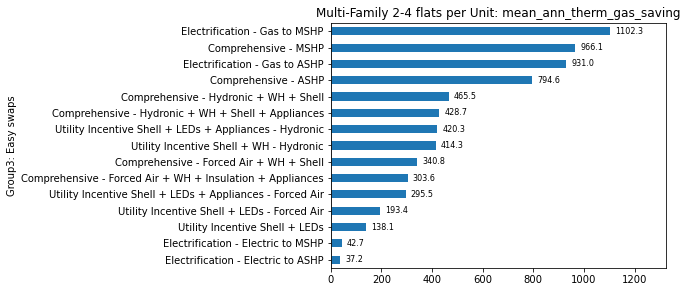

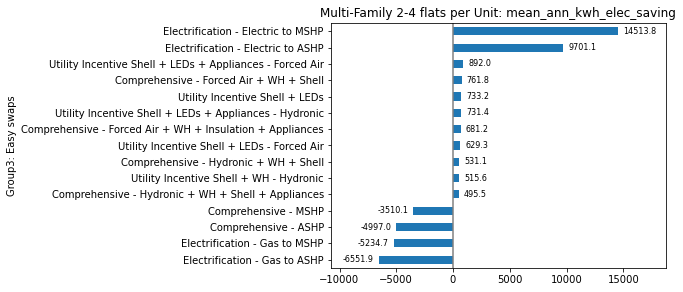

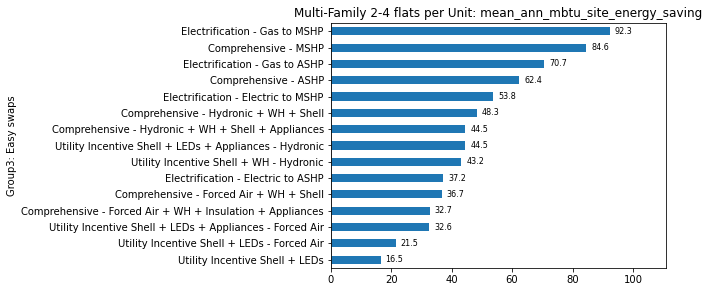

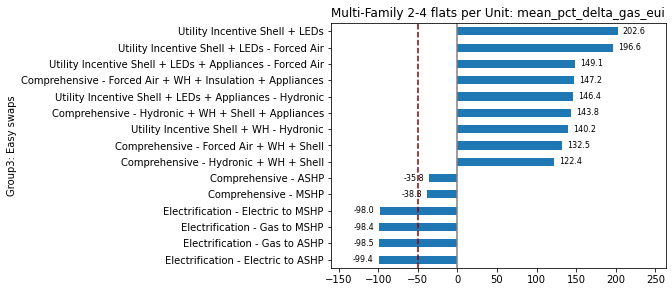

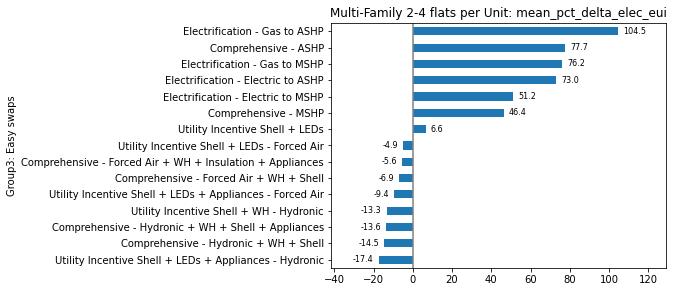

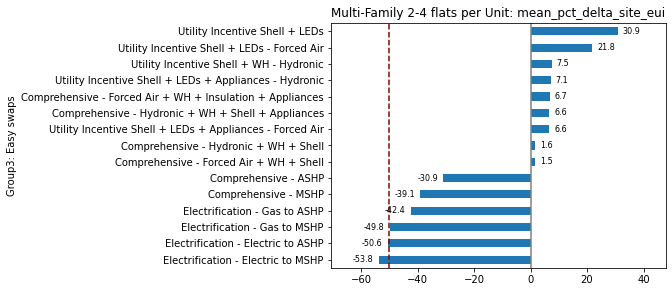

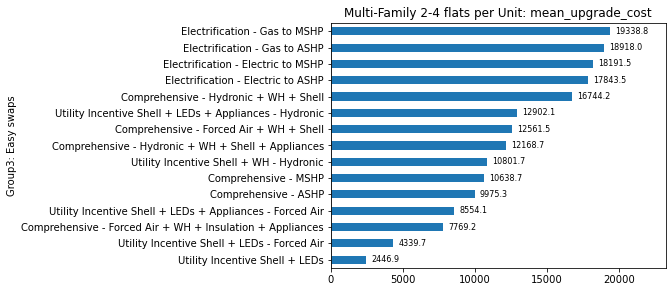

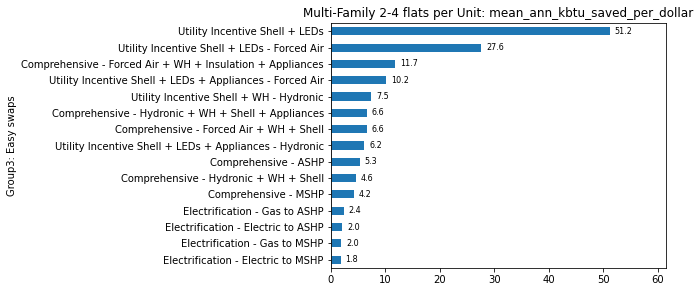

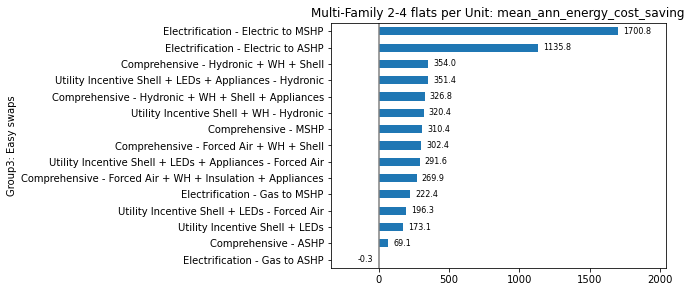

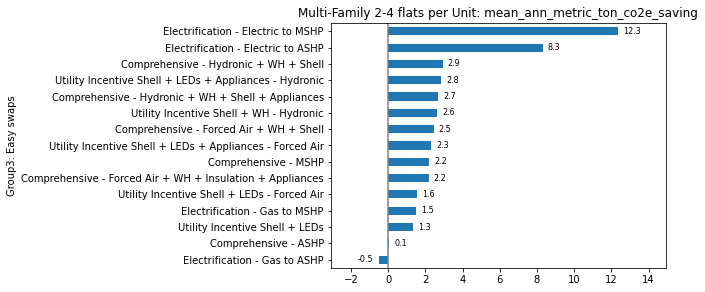

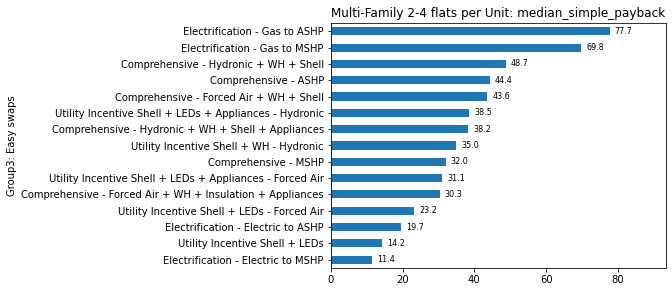

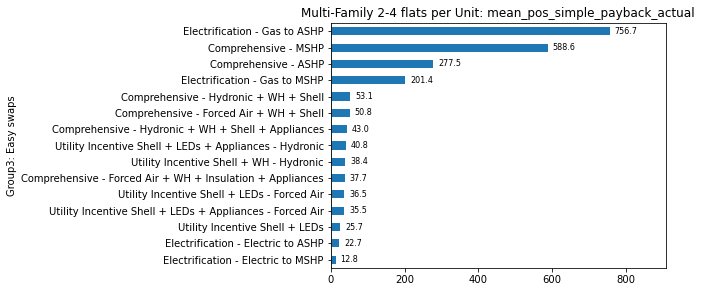

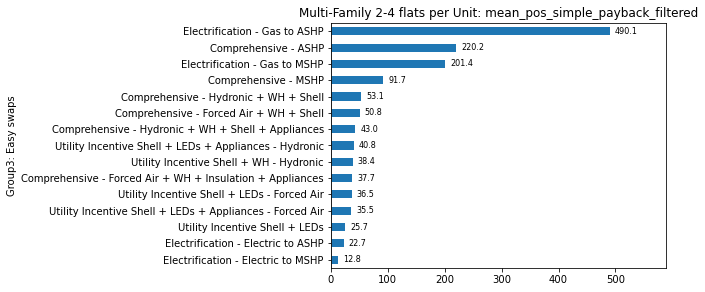

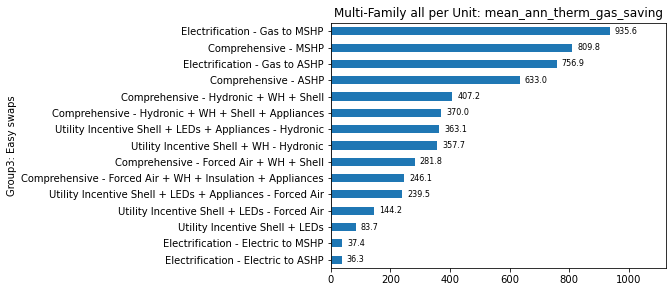

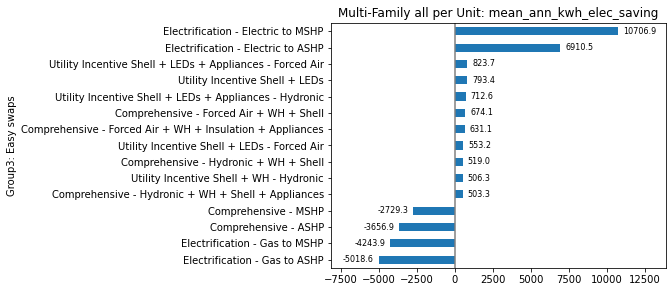

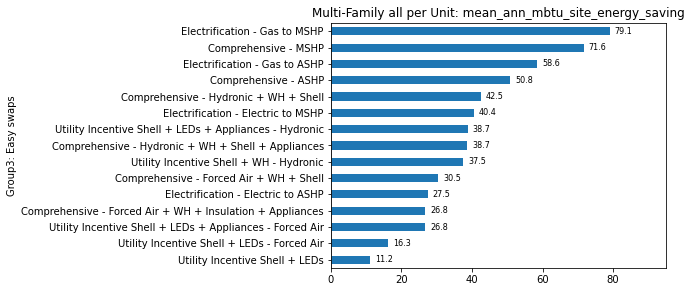

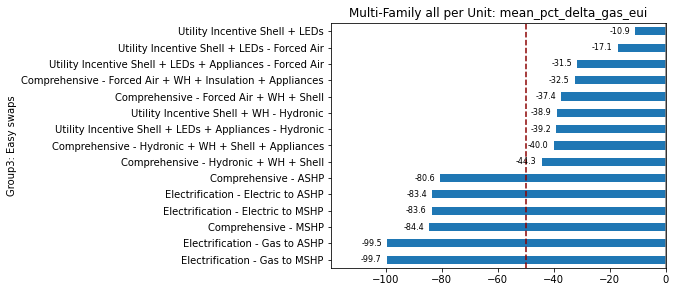

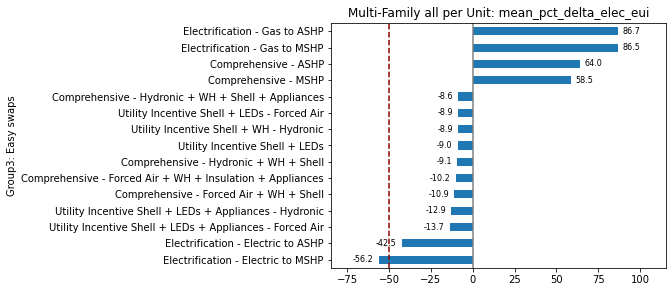

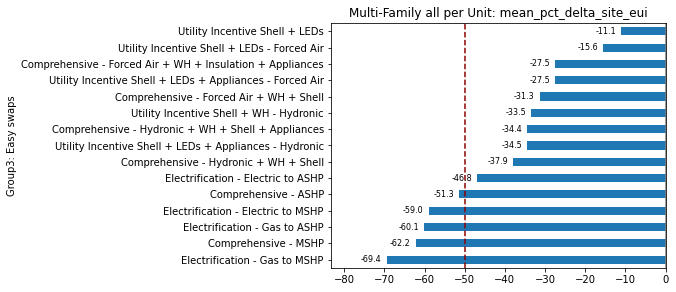

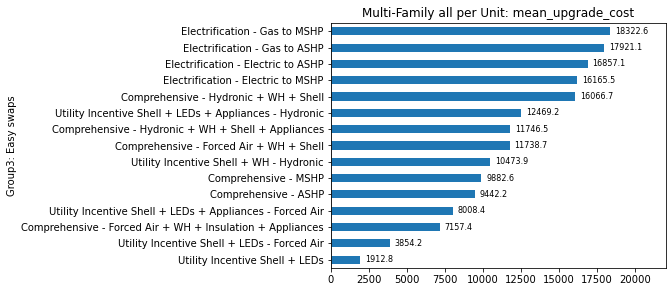

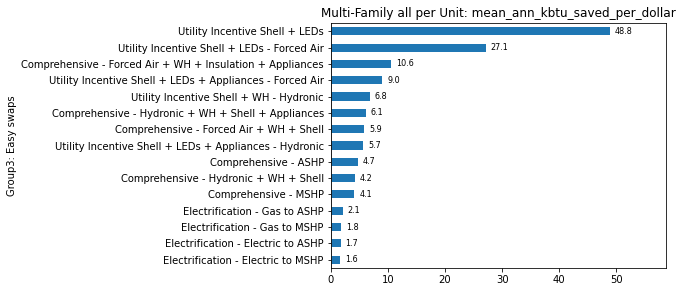

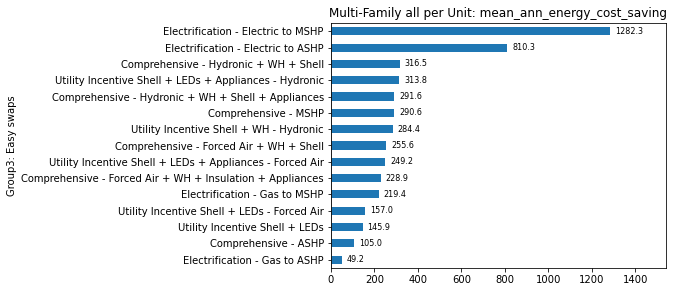

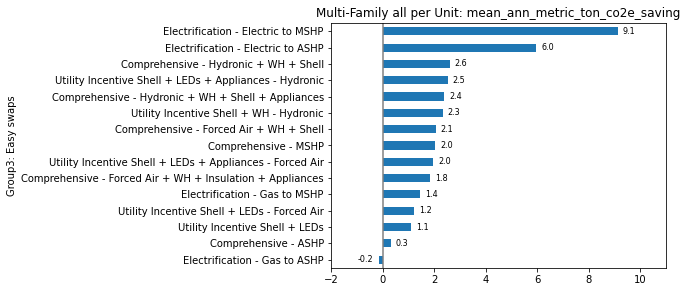

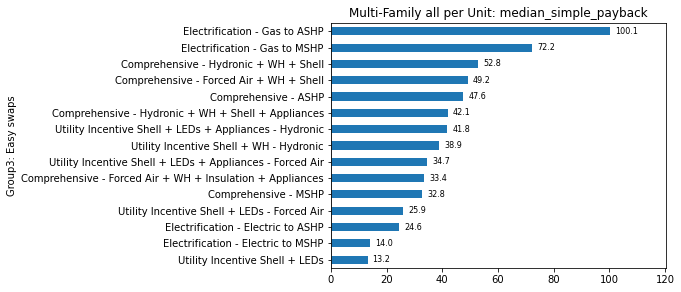

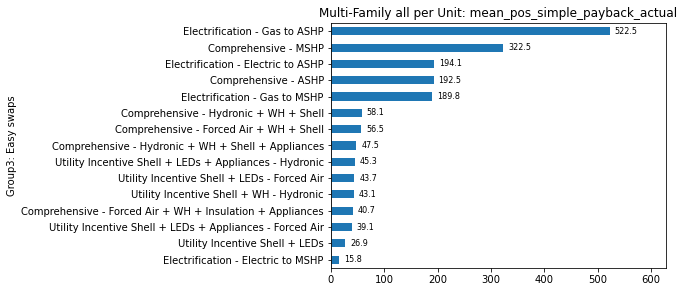

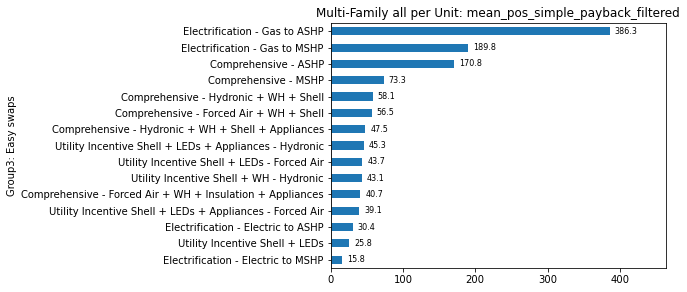

In [51]:
### plot MF-all & MF-2-4 flats (Cook County Avg) ###

for mf_type in summary_upgrades['mf_type'].unique():
    summ_ups = summary_upgrades[
        (~summary_upgrades['upgrade_no'].isnull()) & (summary_upgrades['mf_type']==mf_type)
         ].reset_index(drop=True)

    upgrade_sets = {
        'Group1: Fuel-agnostic upgrades': range(1, 16),
        'Group2: Multi-fuel upgrades': range(16, 44),
        'Group3: Easy swaps': range(44, 53),
    }
    upgrade_set_colors = {
        'Group1: Fuel-agnostic upgrades': 'tab:blue',
        'Group2: Multi-fuel upgrades': 'tab:orange',
        'Group3: Easy swaps': 'tab:green',
    }

    # create subfolder for plots:

    plot_path5 = os.path.join(plot_path, f'mean_values_mf_{mf_type}_cook_cnty_avg')
    if not os.path.exists(plot_path5):
        os.mkdir(plot_path5)
    print(f'plot dir: {plot_path5}\n')

    if NG_rate_multiplier == 1: 
        metrics_to_plot = list(x for x in summary_upgrades.columns if 
                               x.startswith('mean') or x.startswith('median'))
    else:
        metrics_to_plot = ['mean_ann_energy_cost_saving', 
                           'median_simple_payback',
                           'median_comparative_payback',
                           'mean_pos_simple_payback_filtered',
                           'mean_pos_comparative_payback_filtered']

    for metric in metrics_to_plot:
        title_ext = '' if fn_ext == '' else f' ({fn_ext.replace("_"," ").lstrip()})'
        title = f'Multi-Family {mf_type} per Unit: {metric}{title_ext}'
        print(f'Plotting {title}...')


        groupi = summ_ups.loc[:, ['upgrade_name', metric]
                             ].set_index(['upgrade_name']).replace([np.inf, -np.inf], np.nan)

        if metric == 'median_comparative_payback':
            groupi = groupi.replace(0,np.nan).sort_values(by = metric) # make 0 nan
        else:
            groupi = groupi.sort_values(by = metric)
        groupi.index.name = up

        ht = len(groupi)
        fig, ax = plt.subplots(figsize=(6, 0.3*ht))
        groupi.plot.barh(legend=False, title=title, ax=ax)

        # For each bar: Place a label ############################
        rects = ax.patches
        for rect in rects:
            # Get X and Y placement of label from rect.
            x_value = rect.get_width()
            y_value = rect.get_y() + rect.get_height() / 2

            # Number of points between bar and label. Change to your liking.
            space = 5
            # Vertical alignment for positive values
            ha = 'left'

            # If value of bar is negative: Place label left of bar
            if x_value < 0:
                # Invert space to place label to the left
                space *= -1
                # Horizontally align label at right
                ha = 'right'

            # Use X value as label and format number with one decimal place
            label = "{:.1f}".format(x_value)

            # Create annotation
            plt.annotate(
                label,                      # Use `label` as label
                (x_value, y_value),         # Place label at end of the bar
                xytext=(space, 0),          # Horizontally shift label by `space`
                textcoords="offset points", # Interpret `xytext` as offset in points
                va='center',                # Vertically center label
                ha=ha,                      # Horizontally align label differently for
                fontsize=8)                 # positive and negative values. 

        ax.margins(x=0.2)    
        ax.axvline(x=0, linestyle='-', color='gray')
        if (metric[-3:]=='eui') & (ax.get_xlim()[0] < -50):
            ax.axvline(x=-50, linestyle='--', color='darkred')

        filename = f'MF-{mf_type}_upgrades_{iteration}_{metric[5:]}_group{n}{fn_ext}.pdf'
        fig.savefig(os.path.join(plot_path5, filename),
                    bbox_inches='tight')
        